In [2]:
# retina
%config InlineBackend.figure_format = 'retina'

In [287]:
import os
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.table import Table
import eazy

from matplotlib import rcParams
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 20

WD = Path('/data1/hbahk/spherex-photoz/spherex-challenge/challenge')
os.chdir(WD)

from utils import plot_comp_hexbin

In [72]:
syn = Table.read(WD/'data/spherex_synphot.dat', format='ascii.commented_header')
syn[:3]

id,F419,E419,F420,E420,F421,E421,F422,E422,F423,E423,F424,E424,F425,E425,F426,E426,F427,E427,F428,E428,F429,E429,F430,E430,F431,E431,F432,E432,F433,E433,F434,E434,F435,E435,F436,E436,F437,E437,F438,E438,F439,E439,F440,E440,F441,E441,F442,E442,F443,E443,F444,E444,F445,E445,F446,E446,F447,E447,F448,E448,F449,E449,F450,E450,F451,E451,F452,E452,F453,E453,F454,E454,F455,E455,F456,E456,F457,E457,F458,E458,F459,E459,F460,E460,F461,E461,F462,E462,F463,E463,F464,E464,F465,E465,F466,E466,F467,E467,F468,E468,F469,E469,F470,E470,F471,E471,F472,E472,F473,E473,F474,E474,F475,E475,F476,E476,F477,E477,F478,E478,F479,E479,F480,E480,F481,E481,F482,E482,F483,E483,F484,E484,F485,E485,F486,E486,F487,E487,F488,E488,F489,E489,F490,E490,F491,E491,F492,E492,F493,E493,F494,E494,F495,E495,F496,E496,F497,E497,F498,E498,F499,E499,F500,E500,F501,E501,F502,E502,F503,E503,F504,E504,F505,E505,F506,E506,F507,E507,F508,E508,F509,E509,F510,E510,F511,E511,F512,E512,F513,E513,F514,E514,F515,E515,F516,E516,F517,E517,F518,E518,F519,E519,F520,E520
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
180642,-12.93,10.04,4.18,10.46,12.45,10.53,-10.32,11.83,0.6,10.85,-5.49,9.34,2.98,10.72,13.86,9.59,-10.02,10.29,-6.82,10.42,27.23,9.13,-8.28,8.45,-3.51,6.44,2.49,8.21,10.66,8.29,-4.09,9.0,13.52,9.55,34.25,12.5,4.91,5.8,-6.65,6.88,0.72,6.89,4.82,7.01,-0.9,6.57,1.6,5.24,7.11,5.93,1.35,4.65,9.69,5.44,-0.38,6.23,-12.41,5.99,6.43,5.44,-4.11,6.47,-11.08,6.42,2.28,6.19,16.48,11.14,-4.16,6.91,-2.19,6.41,-3.11,10.02,-1.6,7.81,16.47,12.64,8.29,9.36,4.45,9.03,10.84,8.37,-2.91,8.04,7.52,7.34,-4.62,6.25,4.36,7.47,-1.3,7.47,-4.62,7.28,-1.75,7.18,3.17,7.23,1.13,9.37,-6.13,7.6,7.06,8.26,11.44,8.33,13.36,8.02,9.41,8.88,16.02,7.43,0.56,7.71,18.61,8.31,20.02,8.82,10.55,7.34,1.74,6.61,11.86,6.92,0.36,5.69,13.75,5.37,3.66,6.28,9.13,6.88,11.03,7.18,32.55,18.27,0.05,8.07,11.93,14.37,31.63,14.33,-17.03,14.37,13.86,14.41,-23.31,12.61,-2.0,14.43,5.6,11.1,9.79,13.73,1.69,15.94,2.03,16.12,-4.25,15.21,7.88,17.6,-16.08,17.71,6.25,17.38,-47.59,25.32,47.42,23.2,11.77,18.67,34.52,30.58,25.26,25.33,28.14,42.79,-59.15,35.28,60.1,34.4,-26.15,33.87,5.99,35.57,-3.53,32.0,-46.36,28.34,-109.88,35.92,-2.75,34.97,-55.47,39.18,0.74,36.54,-24.96,41.72,-54.64,37.64
180650,11.95,11.1,-17.29,10.8,-9.8,9.43,-5.06,9.01,-2.83,10.11,17.57,10.18,-16.88,10.32,18.33,8.2,-0.08,9.77,3.23,7.9,-0.2,8.22,8.48,8.37,1.34,7.4,7.25,6.74,4.53,7.92,-4.44,8.1,4.6,10.75,3.59,11.03,15

In [66]:
np.argwhere(syn['F480']>100)

array([[   363],
       [   389],
       [   394],
       ...,
       [165948],
       [165973],
       [165981]])

In [69]:
idx_target = 363
phot = np.array(list(syn[idx_target].values()))[1:]
flux = phot[::2]
erro = phot[1::2]
res = eazy.filters.FilterFile(WD/'FILTERS+spherex.res')
idx_sphx = res.search('SPHEREx', verbose=False)
res_sphx = np.array(res.filters)[idx_sphx]
wave = np.array([filt.pivot for filt in res_sphx])

<ErrorbarContainer object of 3 artists>

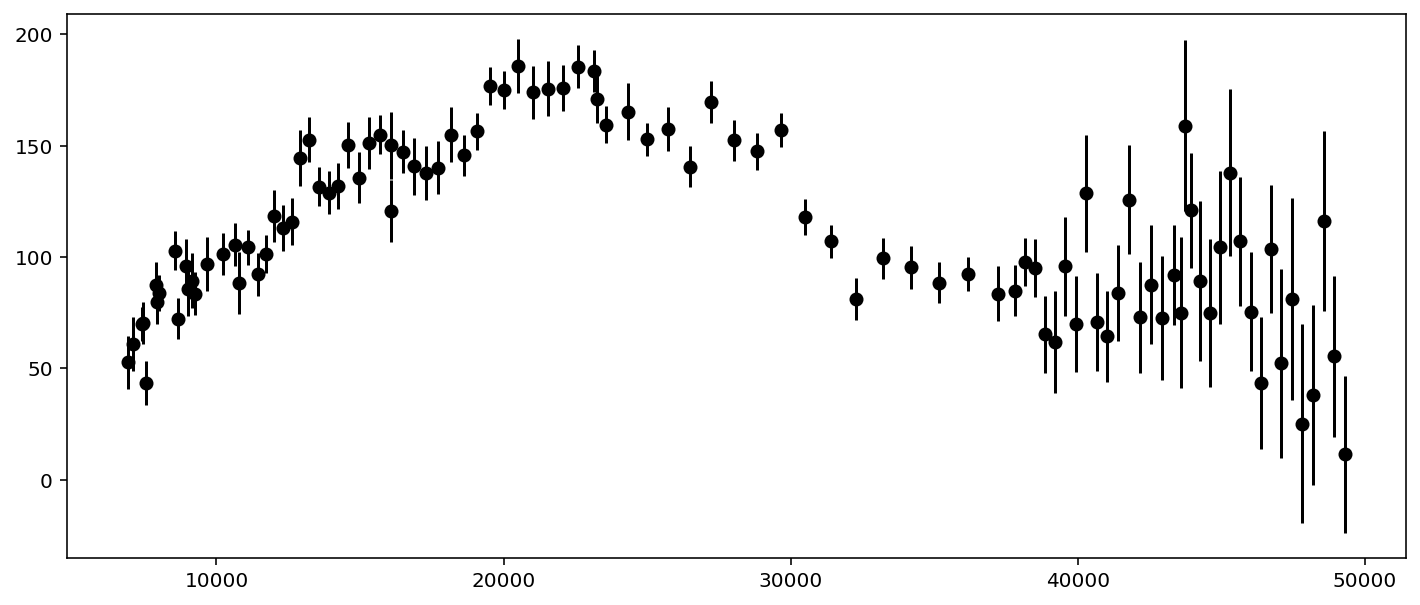

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.errorbar(wave, flux, yerr=erro, fmt='o', color='k')

In [89]:
idx_sphx_band1 = res.search('SPHEREx_Band1', verbose=False)
res_sphx_band1 = np.array(res.filters)[idx_sphx_band1]

filters = res_sphx_band1
fluxes = flux[:17]
errors = erro[:17]

weights = np.empty(len(filters), dtype=float)
for i, filt in enumerate(filters):
    if not hasattr(filt, 'weight'):
        filt.weight = np.trapz(filt.throughput*filt.wave, filt.wave)
    weights[i] = filt.weight

flux_combined = np.average(fluxes, weights=weights)
error_combined = np.sqrt(np.sum(errors**2*weights**2/weights.sum()**2))

pivot_combined_squred = np.average([filt.pivot**2 for filt in filters],
                                   weights=[filt.norm for filt in filters])
pivot_combined = np.sqrt(pivot_combined_squred)

# resample filters into the common wavelength grid
mean_sampling = np.mean([filt.wave[1]-filt.wave[0] for filt in filters])

eazy.filters.FilterDefinition('SPHEREx_Band1_combined', )

[2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51]
[2.51 2.51 2.52 2.51 2.51 2.51 2.51 2.51 2.51 2.51]
[2.51 2.51 2.5  2.51 2.51 2.5  2.51 2.51 2.5  2.51]


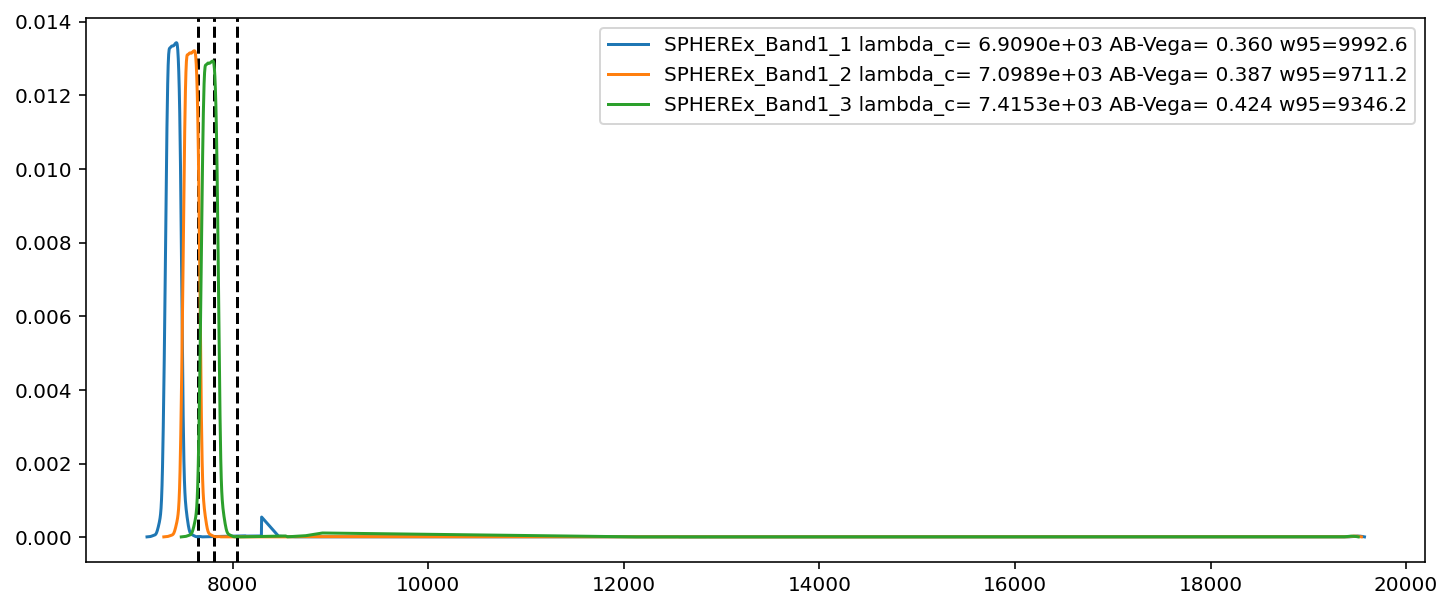

In [154]:
filters = res_sphx
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for filt in filters[:3]:
    # mask = (filt.wave < filt.pivot + 3*filt.rectwidth) & (filt.wave > filt.pivot - 3*filt.rectwidth)
    my_piv = np.sqrt(np.trapz(filt.throughput*filt.wave,filt.wave)/np.trapz(filt.throughput/filt.wave,filt.wave))
    ax.axvline(filt.pivot, color='k', ls='--')
    # ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
    # ax.plot(filt.wave[mask], filt.throughput[mask], '.', label=filt.name)
    ax.plot(filt.wave, filt.throughput, label=filt.name)
    ax.legend()
    print(np.diff(filt.wave)[:10])
ax.set_xlim(7050, 8500)

In [142]:
from utils import make_eazy_filters_spherex
# res_nocut = make_eazy_filters_spherex(WD/'data'/'fiducial_filters_102',
#                                       'FILTERS+spherex_nocut.res', threshold=0)
res_nocut = eazy.filters.FilterFile(WD/'FILTERS+spherex_nocut.res')

Wrote <FILTERS+spherex_nocut.res[.info]>


In [143]:
idx_sphx_nocut = res_nocut.search('SPHEREx', verbose=False)
res_sphx_nocut = np.array(res_nocut.filters)[idx_sphx_nocut]

[2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51 2.52 2.51]
[2.51 2.51 2.52 2.51 2.51 2.51 2.51 2.51 2.51 2.51]
[2.5  2.51 2.51 2.5  2.51 2.51 2.5  2.51 2.51 2.5 ]


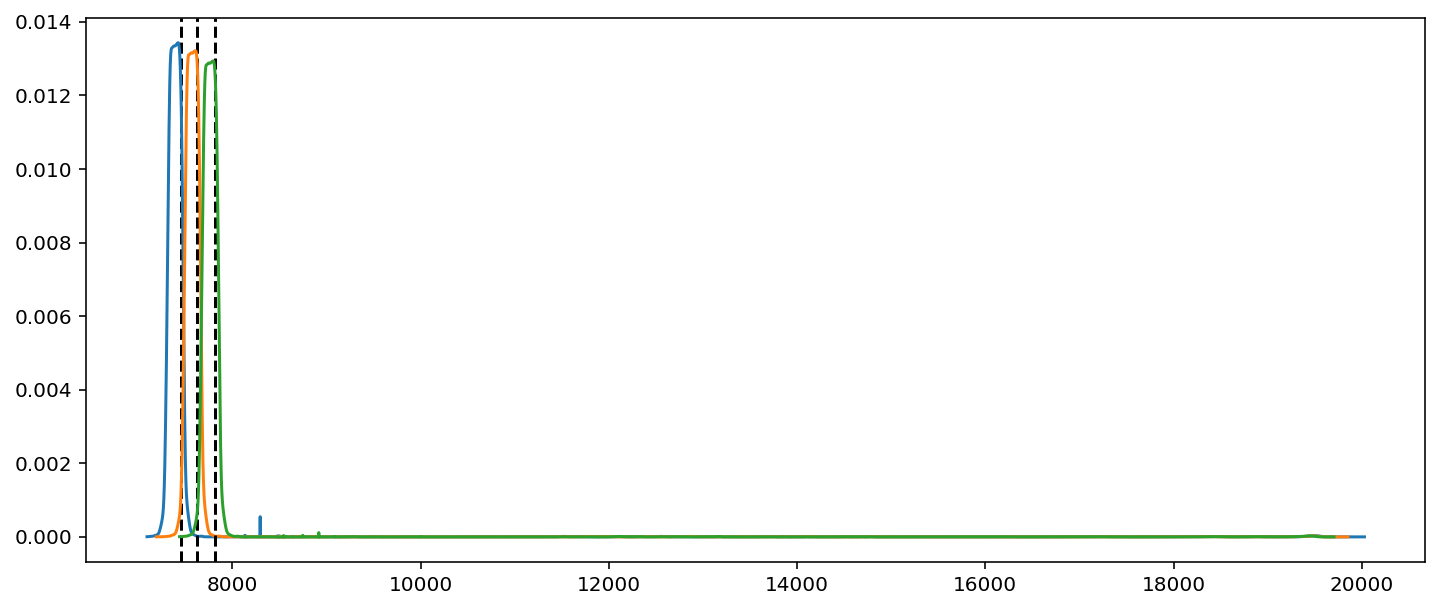

In [156]:
filters = res_sphx_nocut
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for filt in filters[:3]:
    mask = (filt.wave < filt.pivot + 2*filt.rectwidth) & (filt.wave > filt.pivot - 2*filt.rectwidth)
    my_piv = np.sqrt(np.trapz(filt.throughput[mask]*filt.wave[mask],filt.wave[mask])/np.trapz(filt.throughput[mask]/filt.wave[mask],filt.wave[mask]))
    ax.axvline(filt.pivot, color='k', ls='--')
    # ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
    # ax.plot(filt.wave[mask], filt.throughput[mask], '.', label=filt.name)
    ax.plot(filt.wave, filt.throughput, label=filt.name)
    # ax.legend()
    print(np.diff(filt.wave)[:10])
# ax.set_xlim(7050, 8500)

(7250.0, 7600.0)

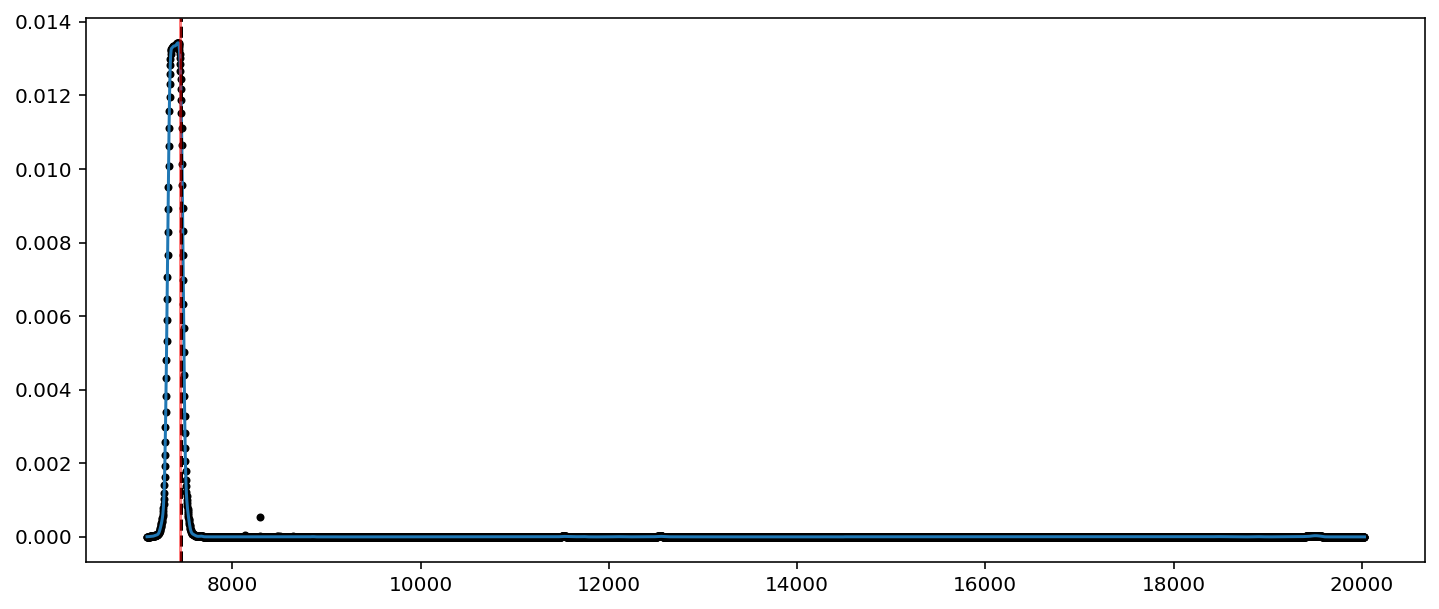

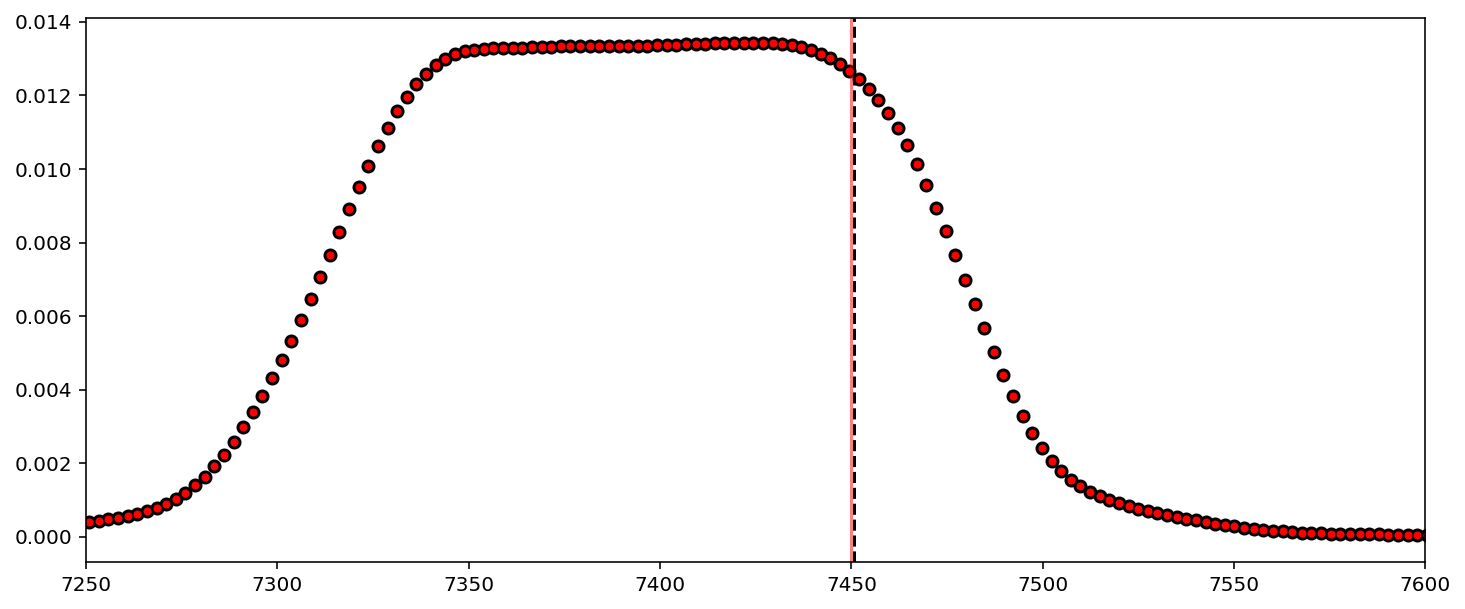

In [172]:
filt = filters[0]
from scipy import signal
thru_med = signal.medfilt(filt.throughput, kernel_size=5)
my_piv = np.sqrt(np.trapz(thru_med*filt.wave,filt.wave)/np.trapz(thru_med/filt.wave,filt.wave))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, '.k', label='original')
ax.plot(filt.wave, thru_med, label='median')
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'ok', label='original')
ax.plot(filt.wave, thru_med, '.r', label='median')
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv, color='r', ls='-', alpha=0.5)
ax.set_xlim(7250, 7600)

(7250.0, 7600.0)

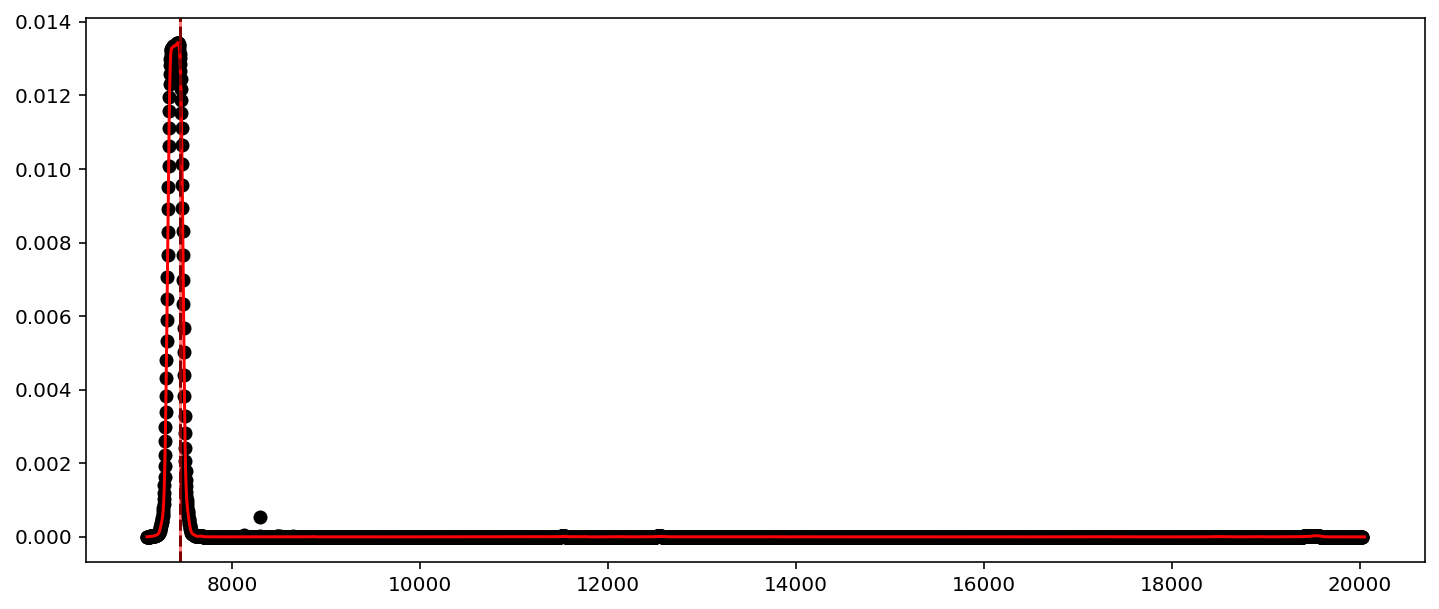

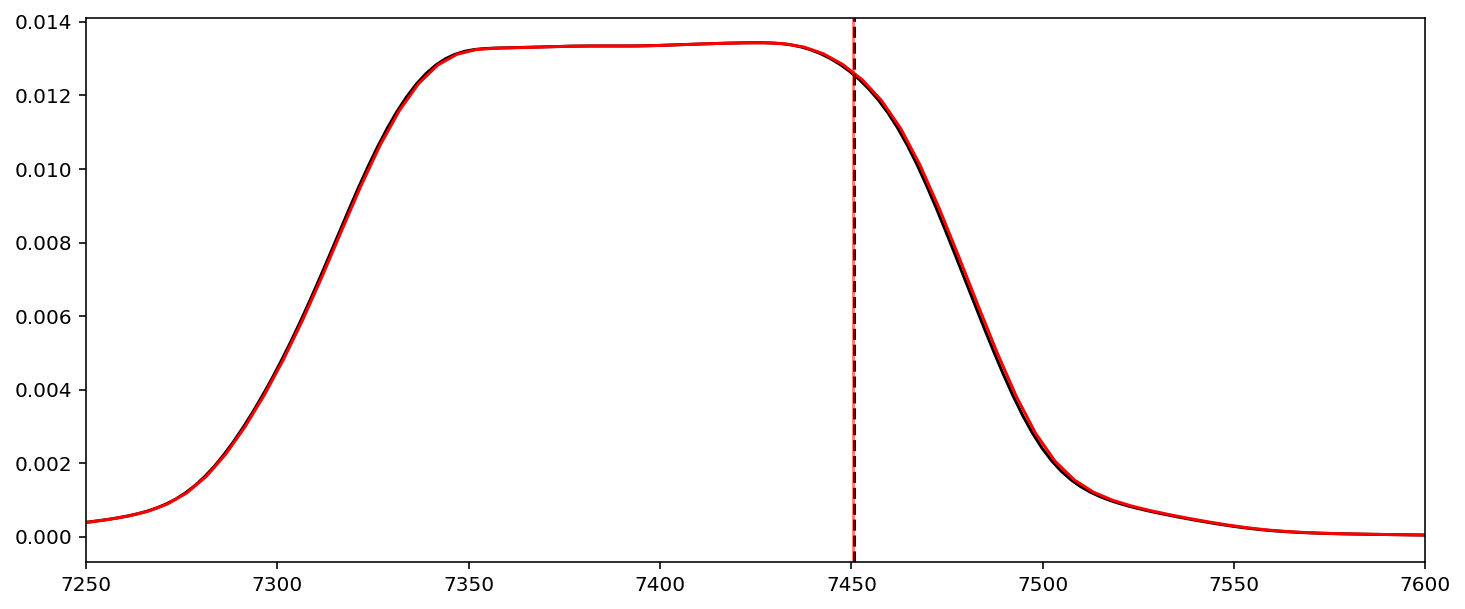

In [173]:
# wave_resample = np.arange(np.min(filt.wave), np.max(filt.wave), 4.)
thru_resample, wave_resample = signal.resample(thru_med, len(filt.wave)//2, t=filt.wave)
my_piv_resample = np.sqrt(np.trapz(thru_resample*wave_resample,wave_resample)/np.trapz(thru_resample/wave_resample,wave_resample))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'ok', label='original')
ax.plot(wave_resample, thru_resample, 'r', label='resampled')
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_resample, color='r', ls='-', alpha=0.5)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(wave_resample, thru_resample, 'r', label='resampled')
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_resample, color='r', ls='-', alpha=0.5)
ax.set_xlim(7250, 7600)

(7250.0, 7600.0)

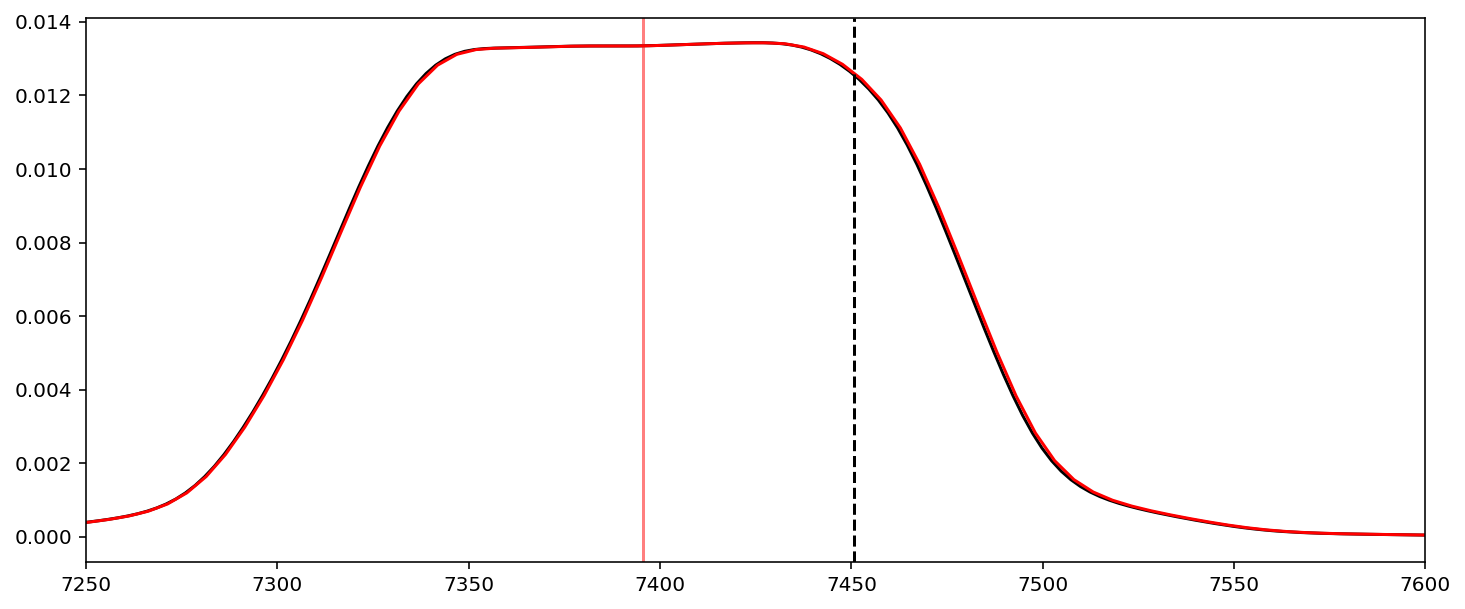

In [210]:
clip_mask = (filt.wave > filt.pivot - 3*filt.rectwidth) & (filt.wave < filt.pivot + 3*filt.rectwidth)
wave_clip, thru_med_clip = filt.wave[clip_mask], thru_med[clip_mask]

thru_clip_resample, wave_clip_resample = signal.resample(thru_med_clip, len(wave_clip)//2, t=wave_clip)
my_piv_clip_resample = np.sqrt(np.trapz(thru_clip_resample*wave_clip_resample,wave_clip_resample)/np.trapz(thru_clip_resample/wave_clip_resample,wave_clip_resample))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(wave_clip_resample, thru_clip_resample, 'r', label='resampled')
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_clip_resample, color='r', ls='-', alpha=0.5)
ax.set_xlim(7250, 7600)

354
177 86


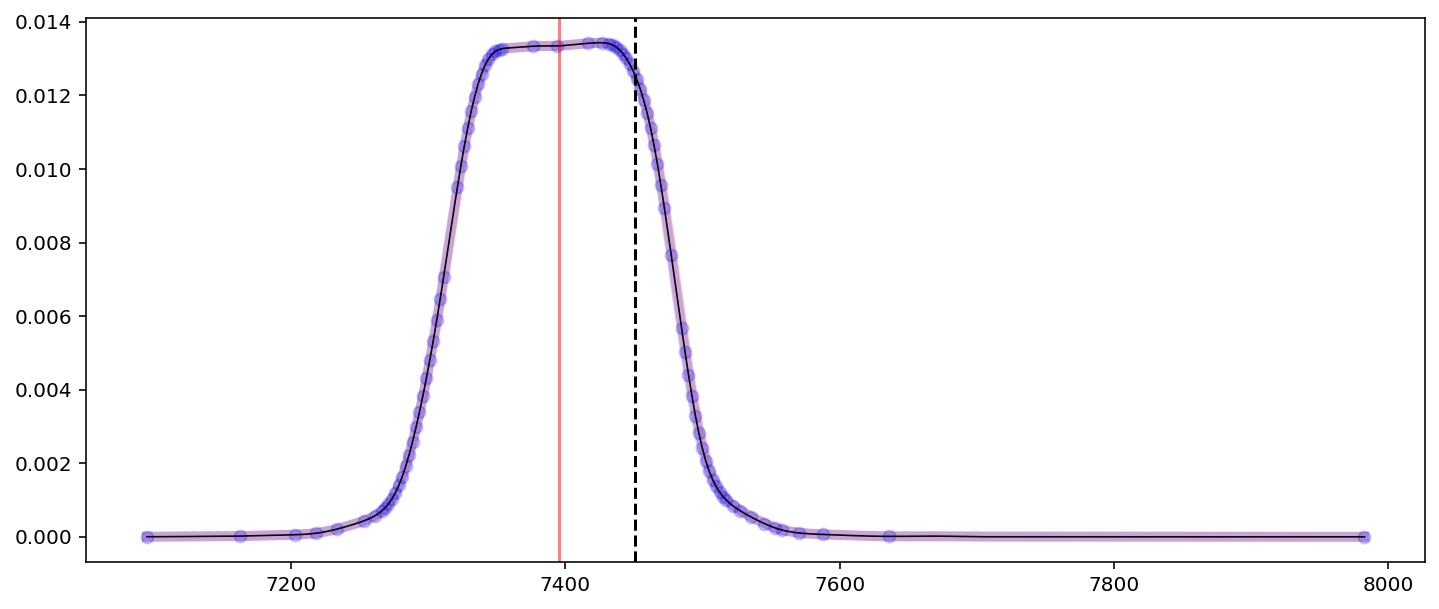

In [211]:
from rdp import rdp
# Ramer-Douglas-Peucker algorithm.
rdp_clip = rdp(np.array([wave_clip, thru_med_clip]).T, epsilon=1e-5)
rdp_clip_wave, rdp_clip_thru = rdp_clip.T
my_piv_clip_rdp = np.sqrt(np.trapz(rdp_clip_thru*rdp_clip_wave,rdp_clip_wave)/np.trapz(rdp_clip_thru/rdp_clip_wave,rdp_clip_wave))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(wave_clip_resample, thru_clip_resample, 'r', label='resampled', alpha=0.2, lw=5)
ax.plot(rdp_clip_wave, rdp_clip_thru, 'o-b', label='rdp', alpha=0.2, lw=5) 
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_clip_resample, color='r', ls='-', alpha=0.5)
ax.plot(wave_clip, filt.throughput[clip_mask], 'k', label='original', lw=0.8)
# ax.set_xlim(7250, 7600)
print(len(wave_clip))
print(len(wave_clip_resample), len(rdp_clip_wave))

5143 37


(7250.0, 7600.0)

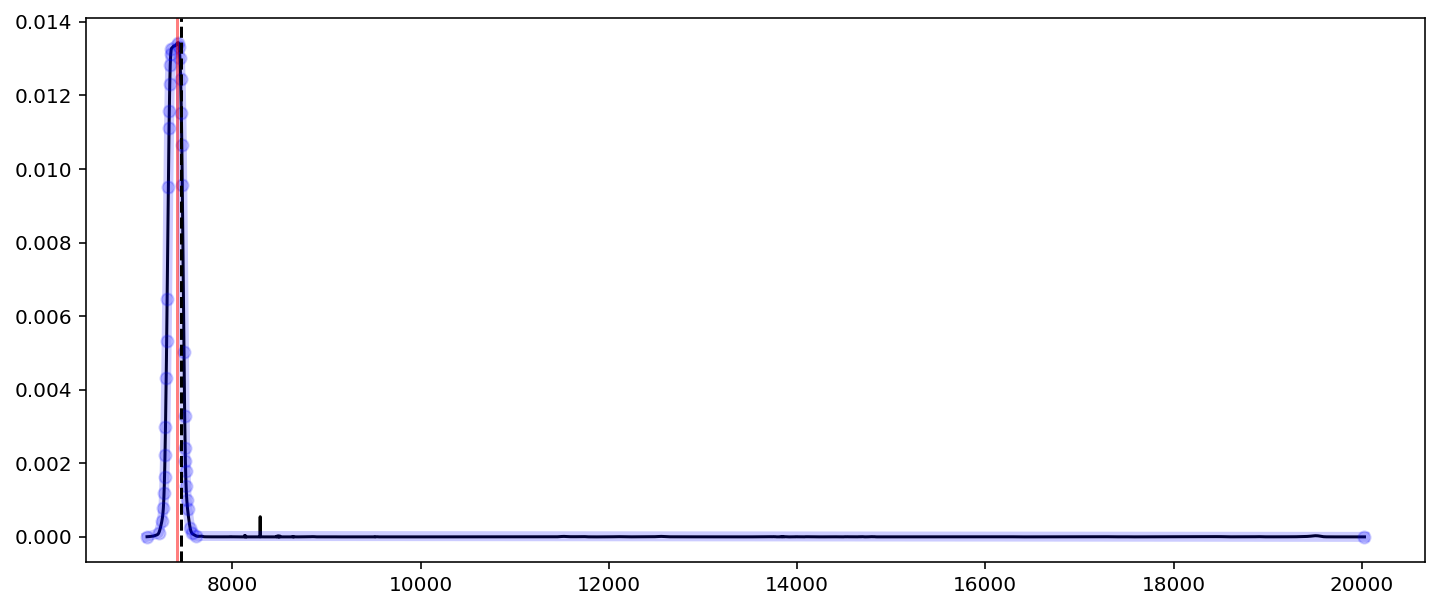

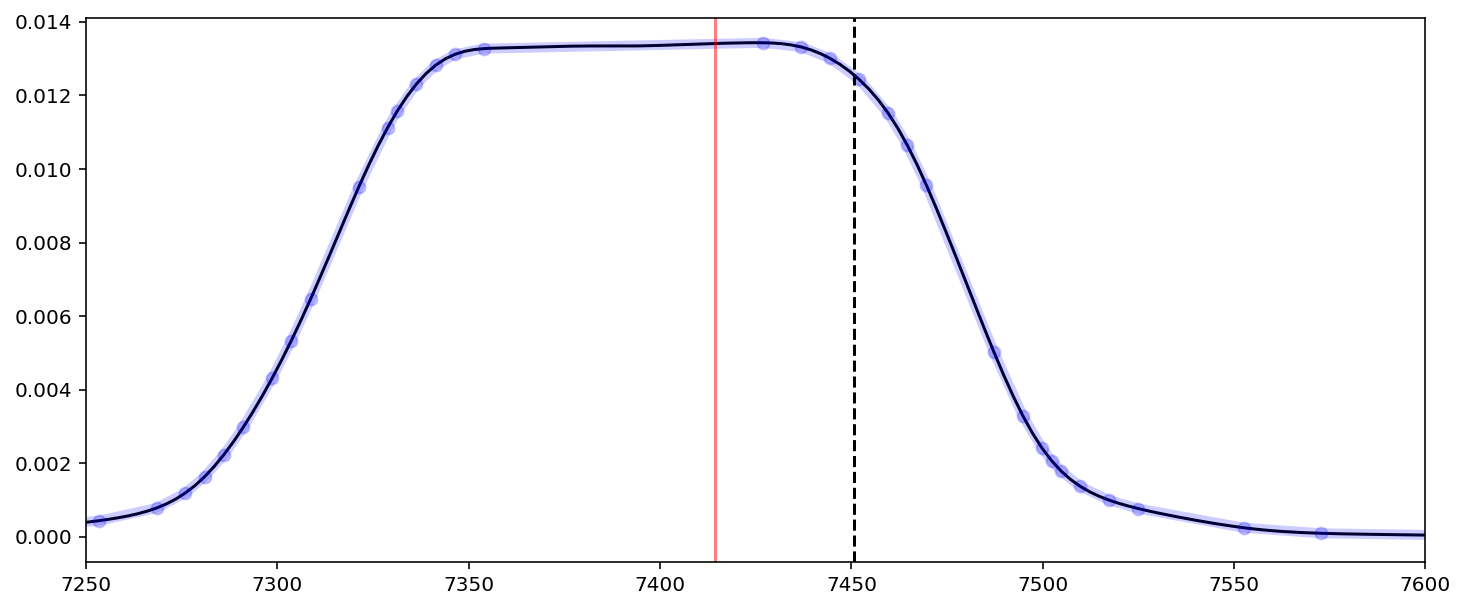

In [209]:
rdp_all = rdp(np.array([filt.wave, thru_med]).T, epsilon=5e-5)
rdp_all_wave, rdp_all_thru = rdp_all.T
my_piv_all_rdp = np.sqrt(np.trapz(rdp_all_thru*rdp_all_wave,rdp_all_wave)/np.trapz(rdp_all_thru/rdp_all_wave,rdp_all_wave))
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(rdp_all_wave, rdp_all_thru, 'o-b', label='rdp', alpha=0.2, lw=5)
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_all_rdp, color='r', ls='-', alpha=0.5)
# ax.set_xlim(7250, 7600)
print(len(filt.wave), len(rdp_all_wave))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(rdp_all_wave, rdp_all_thru, 'o-b', label='rdp', alpha=0.2, lw=5)
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_all_rdp, color='r', ls='-', alpha=0.5)
ax.set_xlim(7250, 7600)

original length: 4694
rdp length: 70


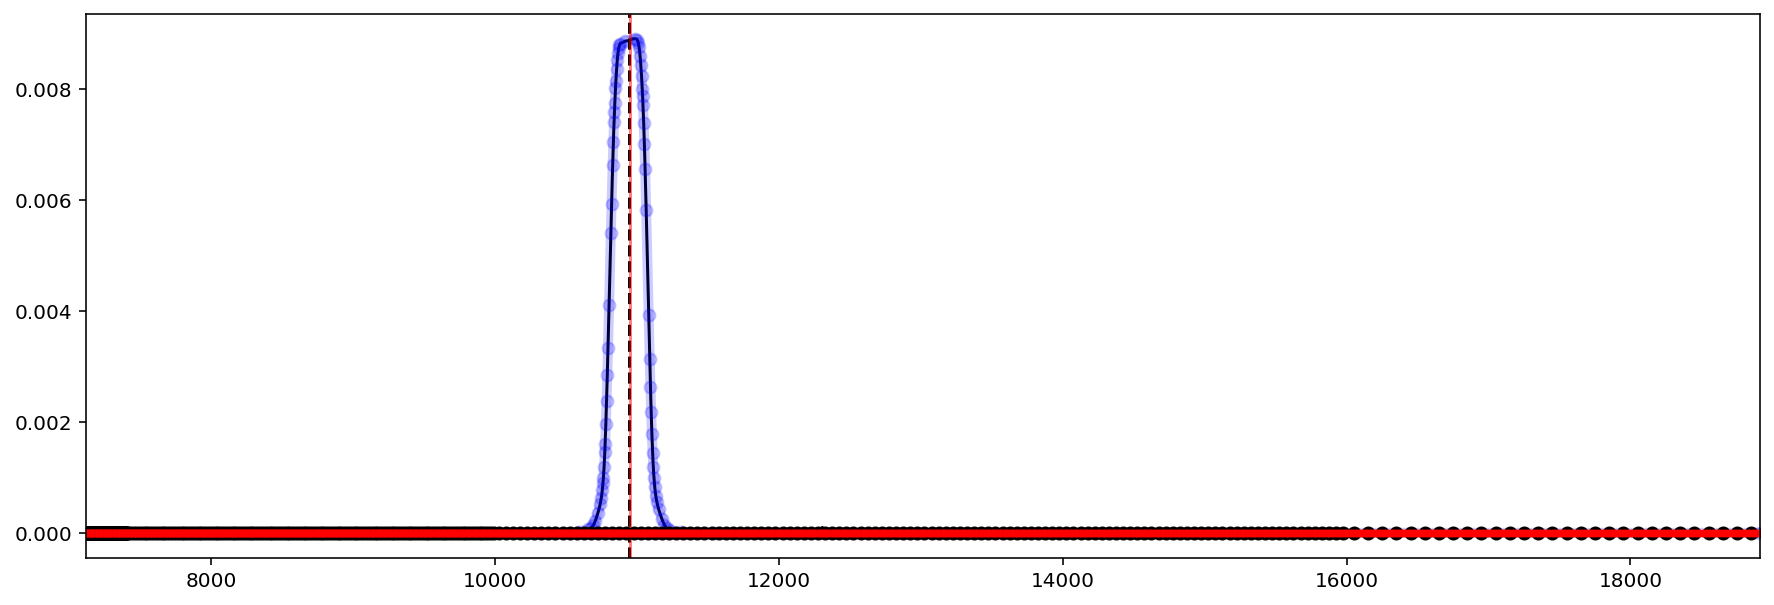

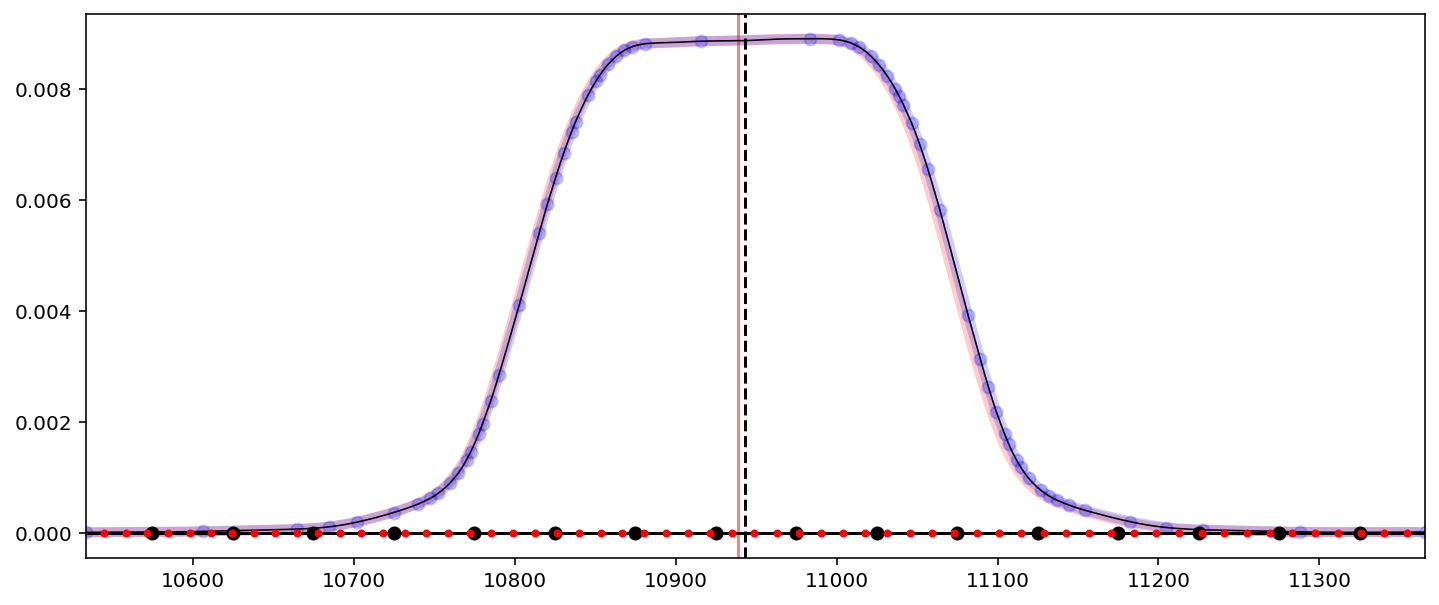

In [263]:
lamb = Table.read("../lambda.def", format='ascii.no_header', names=['wave'])['wave'].value
lamb_test = np.logspace(np.log10(0.7e4), np.log10(30e4), 3000)

filt = filters[17*1-1]
from scipy import signal
thru_med = signal.medfilt(filt.throughput, kernel_size=5)

rdp_all = rdp(np.array([filt.wave, thru_med]).T, epsilon=1e-5)
rdp_all_wave, rdp_all_thru = rdp_all.T
my_piv_all_rdp = np.sqrt(np.trapz(rdp_all_thru*rdp_all_wave,rdp_all_wave)/np.trapz(rdp_all_thru/rdp_all_wave,rdp_all_wave))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(rdp_all_wave, rdp_all_thru, 'o-b', label='rdp', alpha=0.2, lw=5)
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_all_rdp, color='r', ls='-', alpha=0.5)
ax.set_xlim(np.min(filt.wave), np.max(filt.wave))
ax.plot(lamb, np.zeros_like(lamb), 'o-k', label='lambda')
ax.plot(lamb_test, np.zeros_like(lamb_test), '.r', label='lambda_test')

clip_mask = (filt.wave > my_piv_all_rdp- 1.5*filt.rectwidth) & (filt.wave < my_piv_all_rdp + 1.5*filt.rectwidth)
wave_clip, thru_med_clip = filt.wave[clip_mask], thru_med[clip_mask]

thru_clip_resample, wave_clip_resample = signal.resample(thru_med_clip, len(wave_clip)//2, t=wave_clip)
my_piv_clip_resample = np.sqrt(np.trapz(thru_clip_resample*wave_clip_resample,wave_clip_resample)/np.trapz(thru_clip_resample/wave_clip_resample,wave_clip_resample))

rdp_clip = rdp(np.array([wave_clip, thru_med_clip]).T, epsilon=1e-5)
rdp_clip_wave, rdp_clip_thru = rdp_clip.T
my_piv_clip_rdp = np.sqrt(np.trapz(rdp_clip_thru*rdp_clip_wave,rdp_clip_wave)/np.trapz(rdp_clip_thru/rdp_clip_wave,rdp_clip_wave))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(wave_clip_resample, thru_clip_resample, 'r', label='resampled', alpha=0.2, lw=5)
ax.plot(rdp_clip_wave, rdp_clip_thru, 'o-b', label='rdp', alpha=0.2, lw=5) 
ax.axvline(filt.pivot, color='k', ls='--')
ax.axvline(my_piv_clip_resample, color='r', ls='-', alpha=0.5)
ax.plot(wave_clip, filt.throughput[clip_mask], 'k', label='original', lw=0.8)
ax.set_xlim(np.min(rdp_clip_wave), np.max(rdp_clip_wave))
ax.plot(lamb, np.zeros_like(lamb), 'o-k', label='lambda')
ax.plot(lamb_test, np.zeros_like(lamb_test), '.r', label='lambda_test')

print(f'original length: {len(filt.wave)}')
print(f'rdp length: {len(rdp_all_wave)}')

we need to make a dedicated lambda file...!!

5994


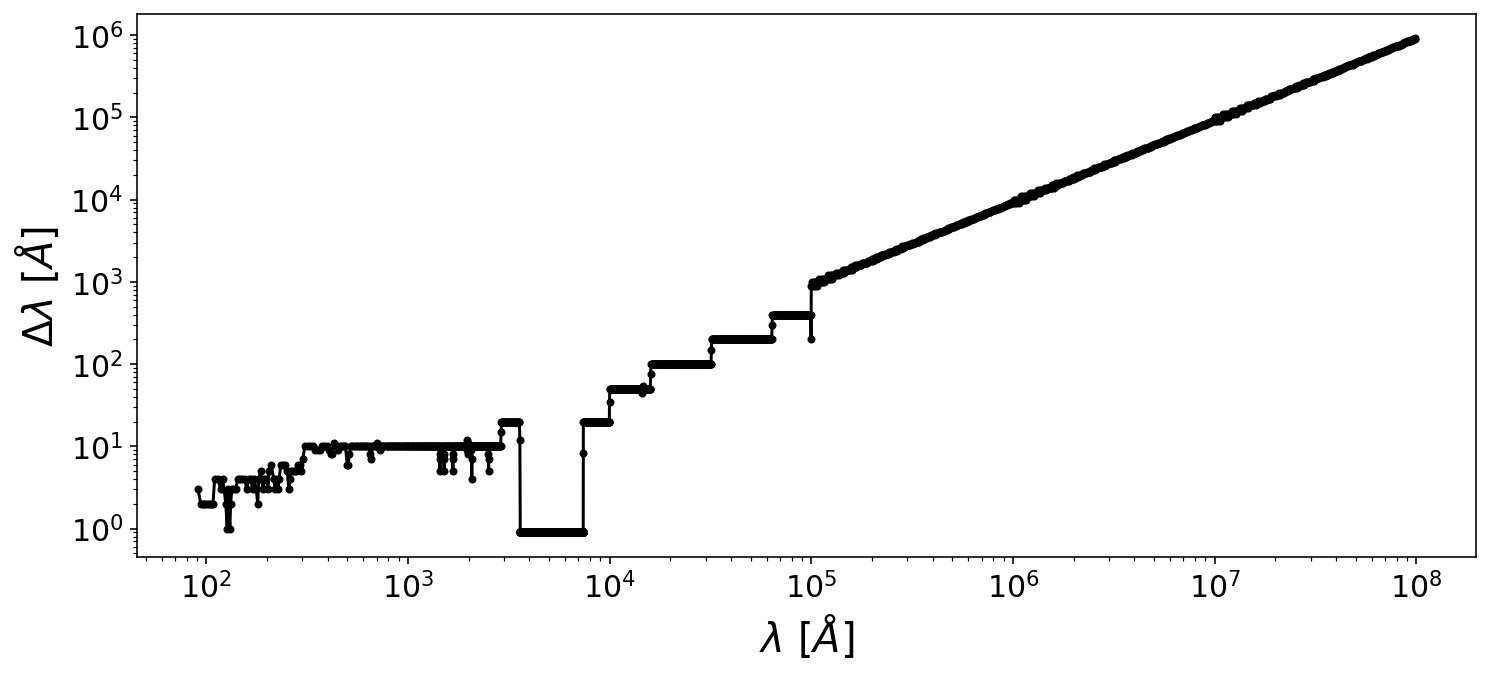

In [330]:
lamb = Table.read("../lambda.def", format='ascii.no_header', names=['wave'])['wave'].value
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(lamb[:-1], np.diff(lamb), '.-k', label='lambda')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$ [$\AA$]')
ax.set_ylabel(r'$\Delta \lambda$ [$\AA$]')
print(len(lamb))

-0.003417552516111755 1.8438135257310933 -0.014057234102438088


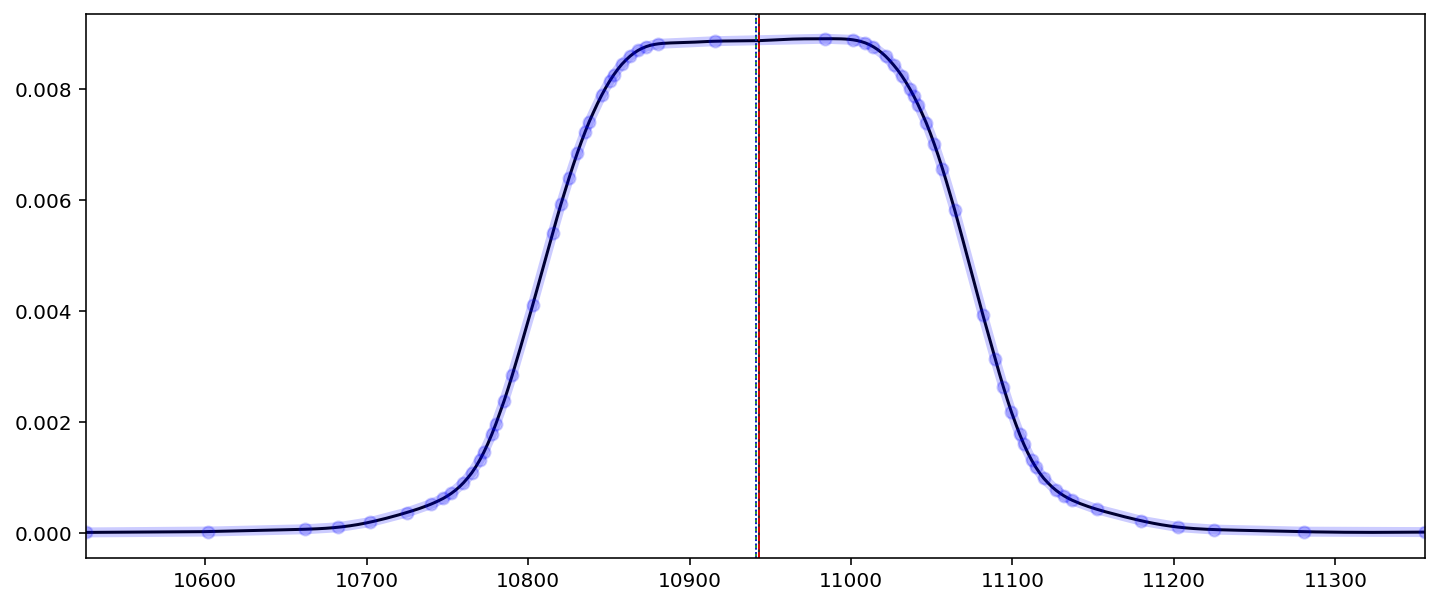

In [273]:
filt = filters[17*1-1]
epsilon_rdp = 1e-5

from scipy import signal
thru_med = signal.medfilt(filt.throughput, kernel_size=5)

pivot = np.sqrt(np.trapz(thru_med*filt.wave,filt.wave)/np.trapz(thru_med/filt.wave,filt.wave))

clip_mask = (filt.wave > filt.pivot - 3*filt.rectwidth) & (filt.wave < filt.pivot + 3*filt.rectwidth)
wave_clip, thru_med_clip = filt.wave[clip_mask], thru_med[clip_mask]

pivot_clip = np.sqrt(np.trapz(thru_med_clip*wave_clip,wave_clip)/np.trapz(thru_med_clip/wave_clip,wave_clip))

clip_mask_2nd = (filt.wave > pivot_clip - 1.5*filt.rectwidth) & (filt.wave < pivot_clip + 1.5*filt.rectwidth)
wave_clip_2nd, thru_med_clip_2nd = filt.wave[clip_mask_2nd], thru_med[clip_mask_2nd]

rdp_reduced = rdp(np.array([wave_clip_2nd, thru_med_clip_2nd]).T, epsilon=epsilon_rdp)
wave_rdp, thru_rdp = rdp_reduced.T

pivot_rdp = np.sqrt(np.trapz(thru_rdp*wave_rdp,wave_rdp)/np.trapz(thru_rdp/wave_rdp,wave_rdp))

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(filt.wave, filt.throughput, 'k', label='original')
ax.plot(wave_rdp, thru_rdp, 'o-b', label='rdp', alpha=0.2, lw=5)
ax.axvline(filt.pivot, color='k', ls='-', lw=0.8)
ax.axvline(pivot, color='r', ls='--', lw=0.8)
ax.axvline(pivot_clip, color='g', ls='--', lw=0.8)
ax.axvline(pivot_rdp, color='b', ls=':', lw=0.8)
ax.set_xlim(np.min(filt.wave), np.max(filt.wave))
ax.set_xlim(np.min(wave_rdp), np.max(wave_rdp))

print(filt.pivot - pivot, pivot- pivot_clip, pivot_clip - pivot_rdp)

In [276]:
res_nocut = make_eazy_filters_spherex(WD/'data'/'fiducial_filters_102',
                                      'FILTERS+spherex_reduced.res', epsilon_rdp=1e-5)

Wrote <FILTERS+spherex_reduced.res[.info]>


Text(0, 0.5, 'Throughput')

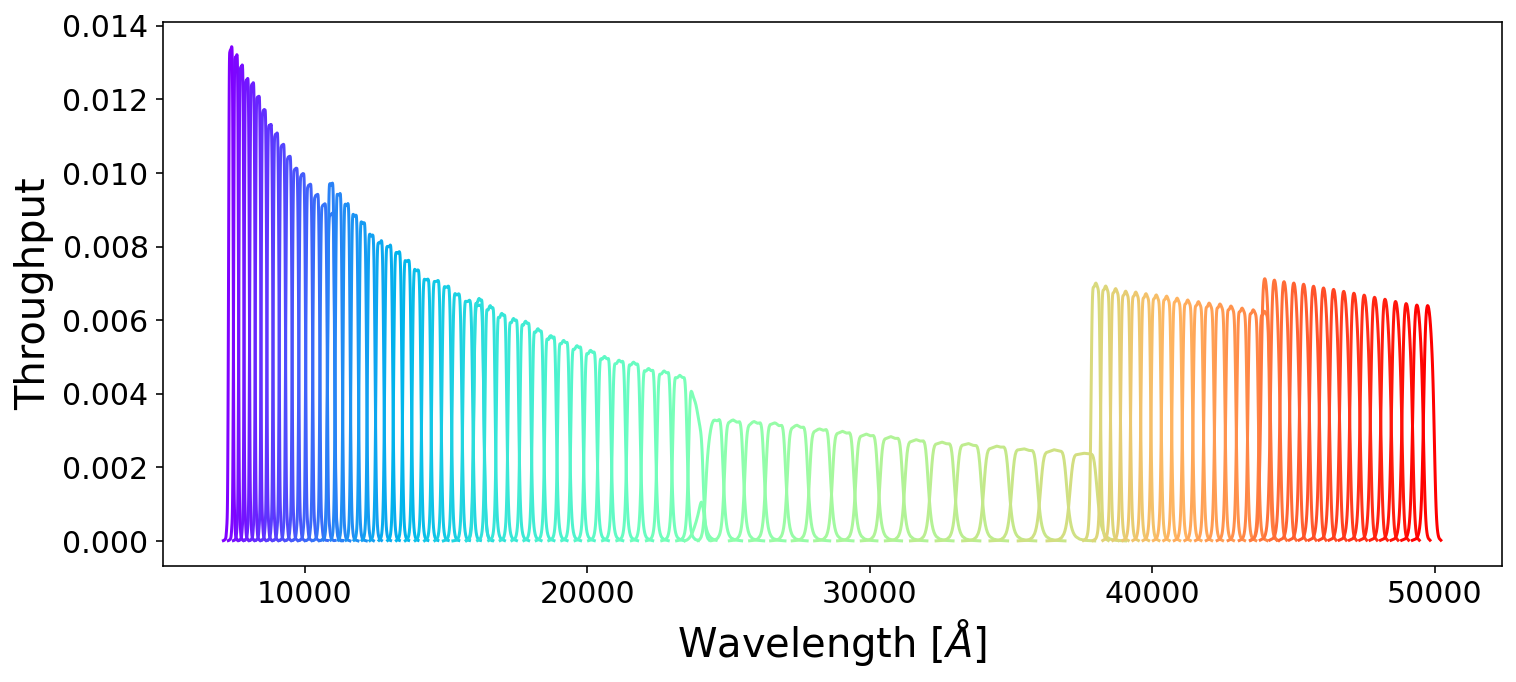

In [289]:
res = eazy.filters.FilterFile(WD/'FILTERS+spherex_reduced.res')

res_sphx = np.array(res.filters)[res.search('SPHEREx', verbose=False)]
Nchan_total = len(res_sphx)
colors = plt.cm.rainbow(np.linspace(0, 1, Nchan_total))
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
for i, filt in enumerate(res_sphx):
    ax.plot(filt.wave, filt.throughput, color=colors[i])

ax.set_xlabel(r'Wavelength [$\AA$]')
ax.set_ylabel('Throughput')

7130.09 11355.7
11355.7 16626.8
16626.8 24323.2
24323.2 39051.6
39051.6 44465.0
44465.0 50209.5
2000


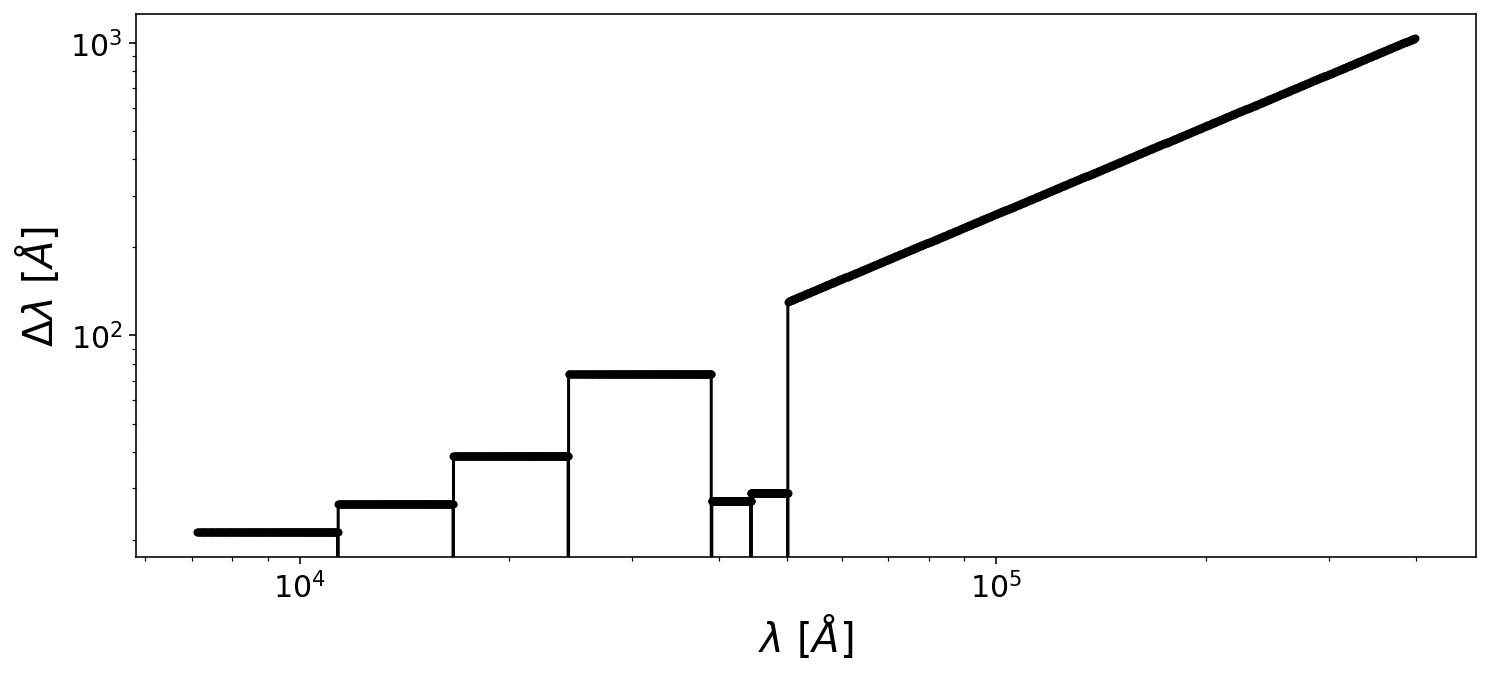

In [328]:
lamb_size = 1000
lamb_size_band = 200
zmax = 6.
lamb_list = []
lamb_max_before = None
for band in range(1,7):
    idx_band = res.search(f'SPHEREx_Band{band}', verbose=False)
    res_band = np.array(res.filters)[idx_band]
    
    lamb_min = np.min(res_band[0].wave) if band==1 else lamb_max_before
    lamb_max = np.max(res_band[-1].wave) #* (1 + zmax)
    
    # lamb_list.append(np.logspace(np.log10(lamb_min), np.log10(lamb_max), lamb_size_band))
    lamb_list.append(np.linspace(lamb_min, lamb_max, lamb_size_band))
    print(lamb_min, lamb_max)
    
    lamb_max_before = lamb_max

lamb_list.append(np.logspace(np.log10(lamb_max_before), np.log10(4e5), lamb_size - lamb_size_band))
# lamb_list.append(np.logspace(lamb_max_before, 30e4, lamb_size - 6*lamb_size_band))
lamb = np.concatenate(lamb_list)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(lamb[:-1], np.diff(lamb), '.-k', label='lambda')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\lambda$ [$\AA$]')
ax.set_ylabel(r'$\Delta \lambda$ [$\AA$]')
print(len(lamb))
    

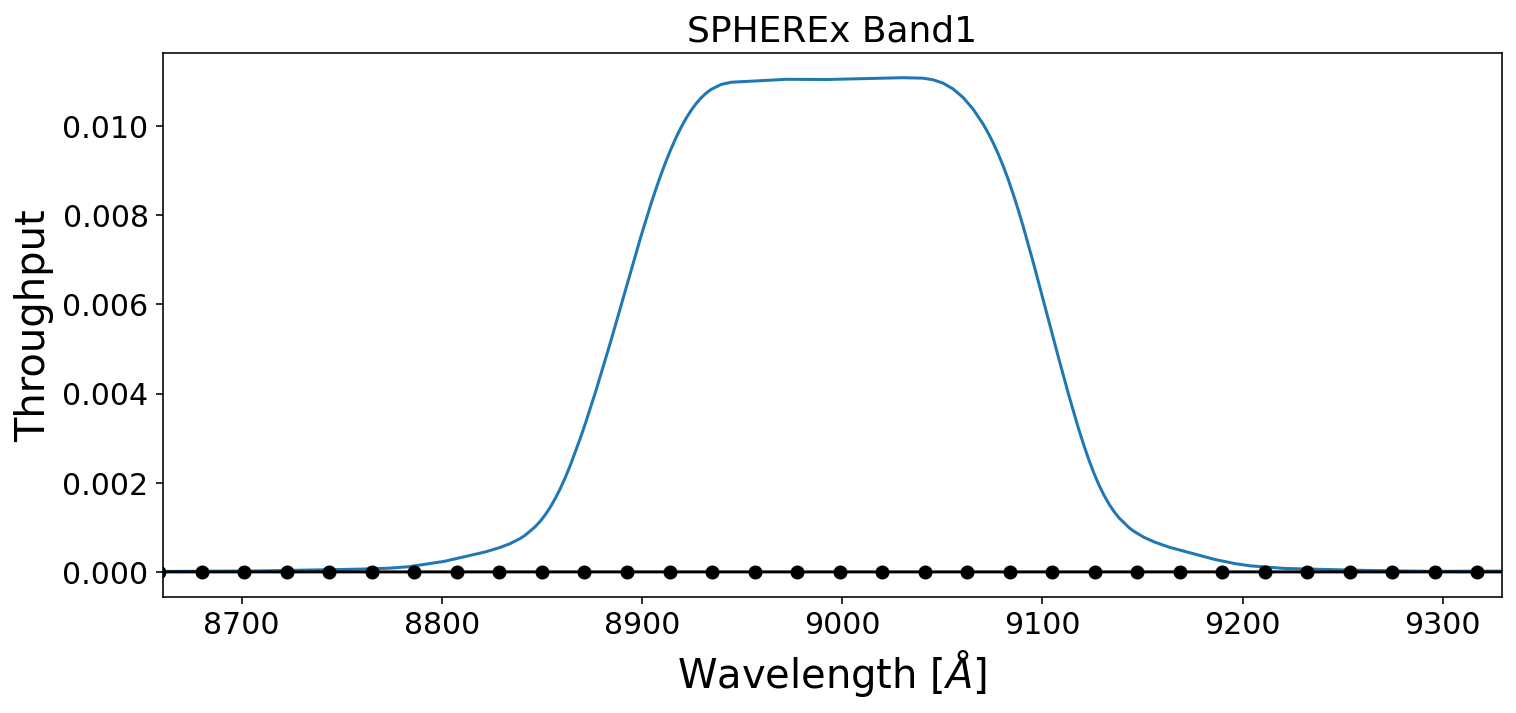

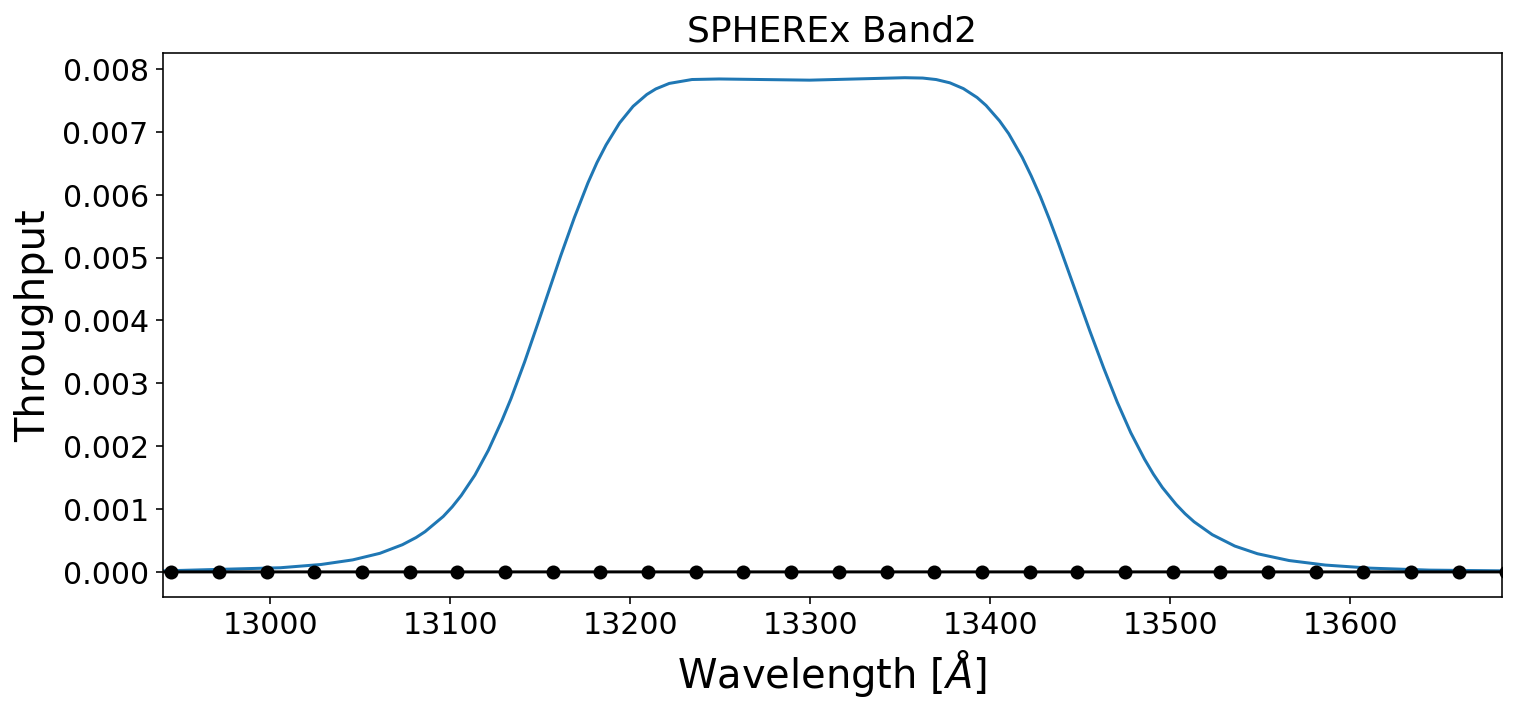

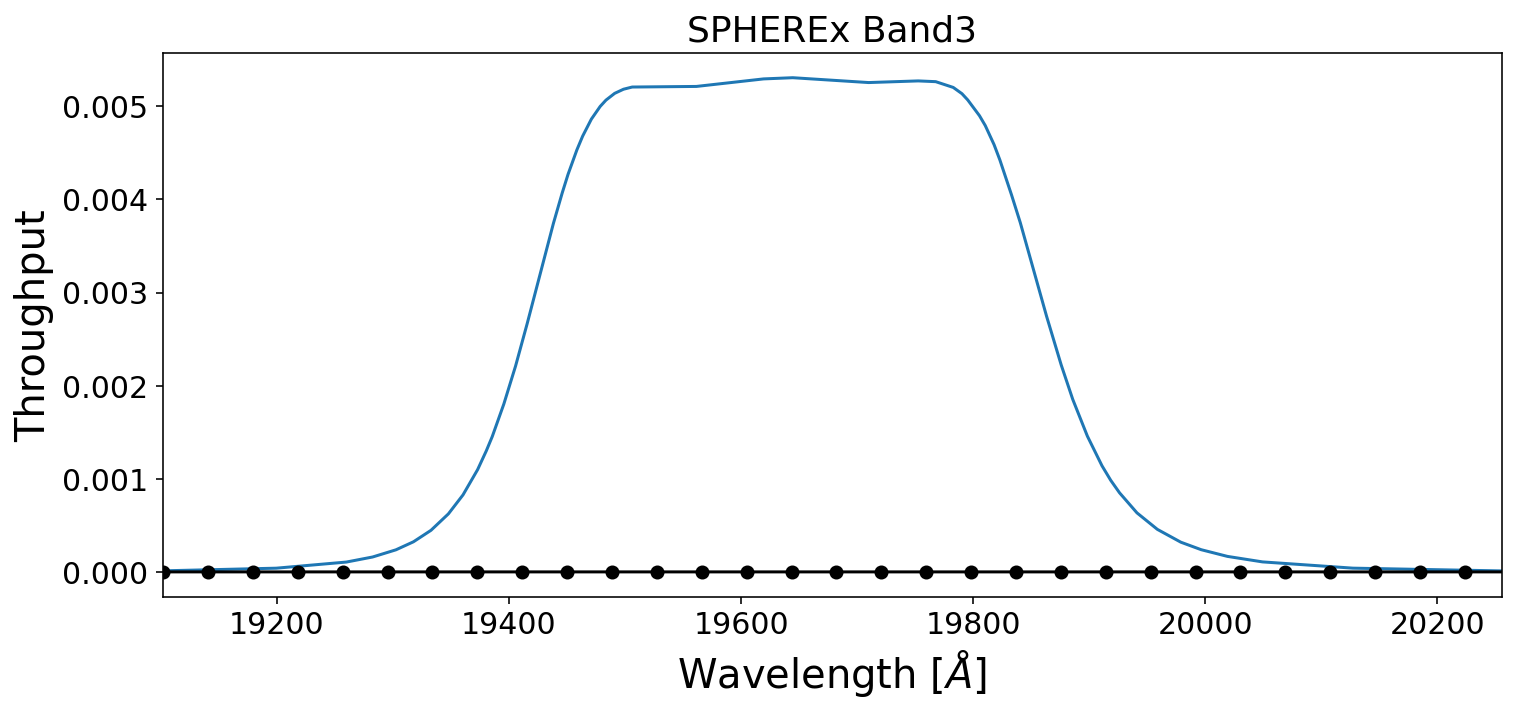

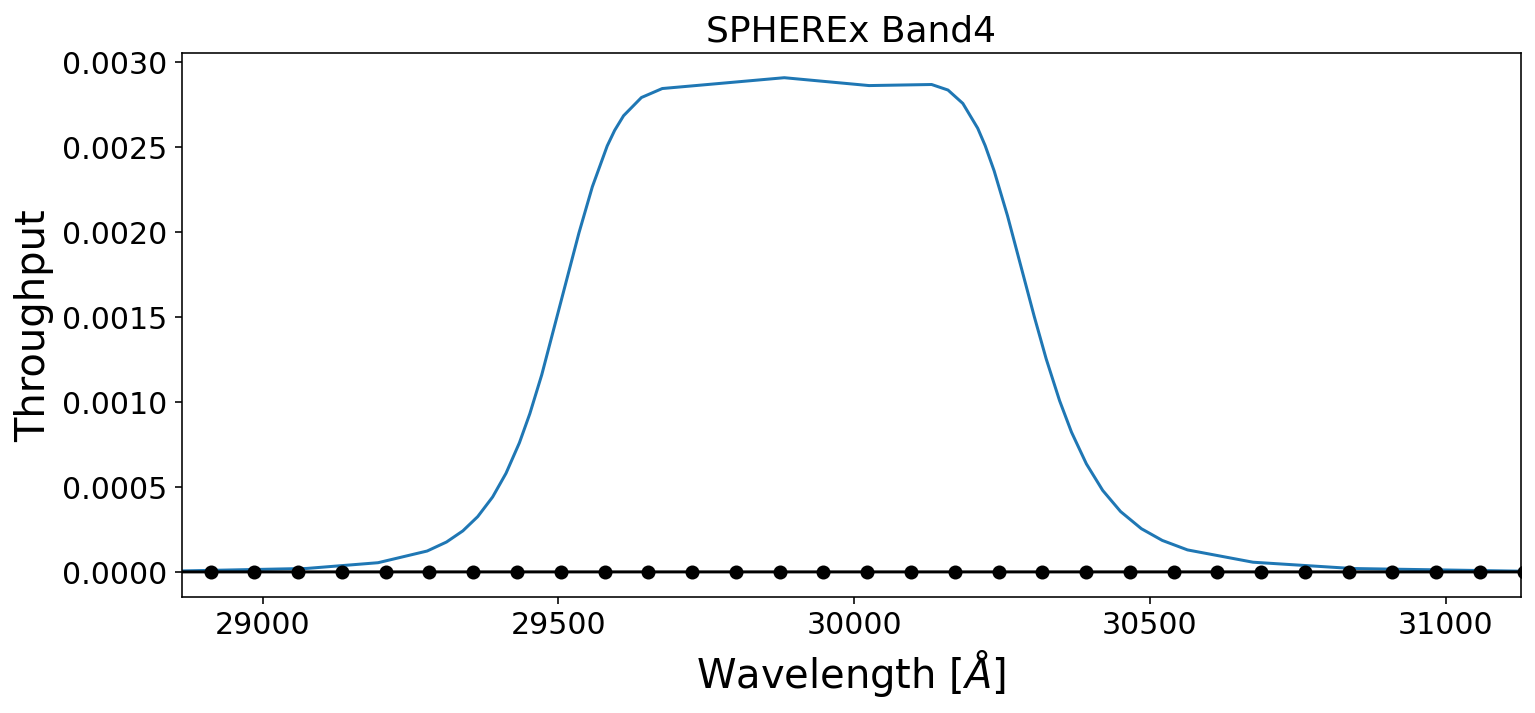

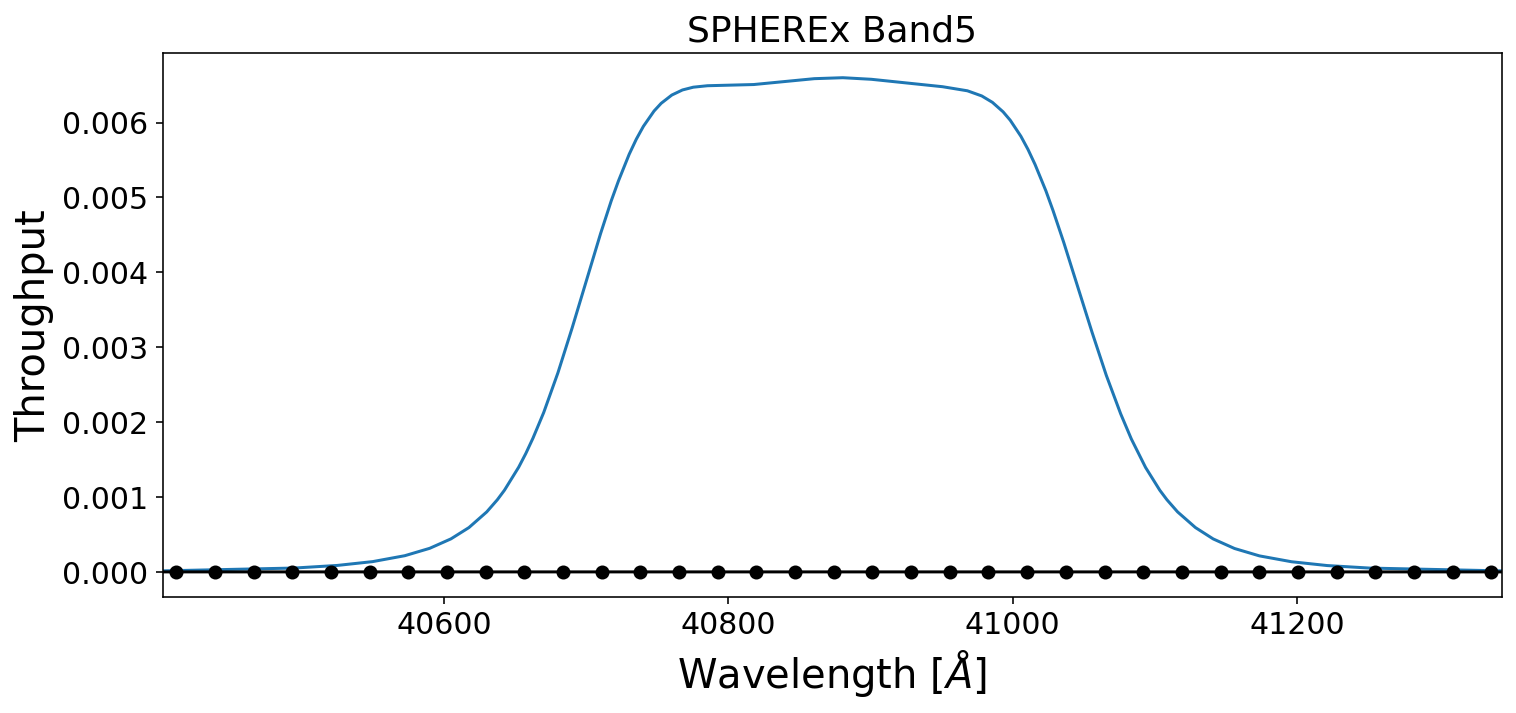

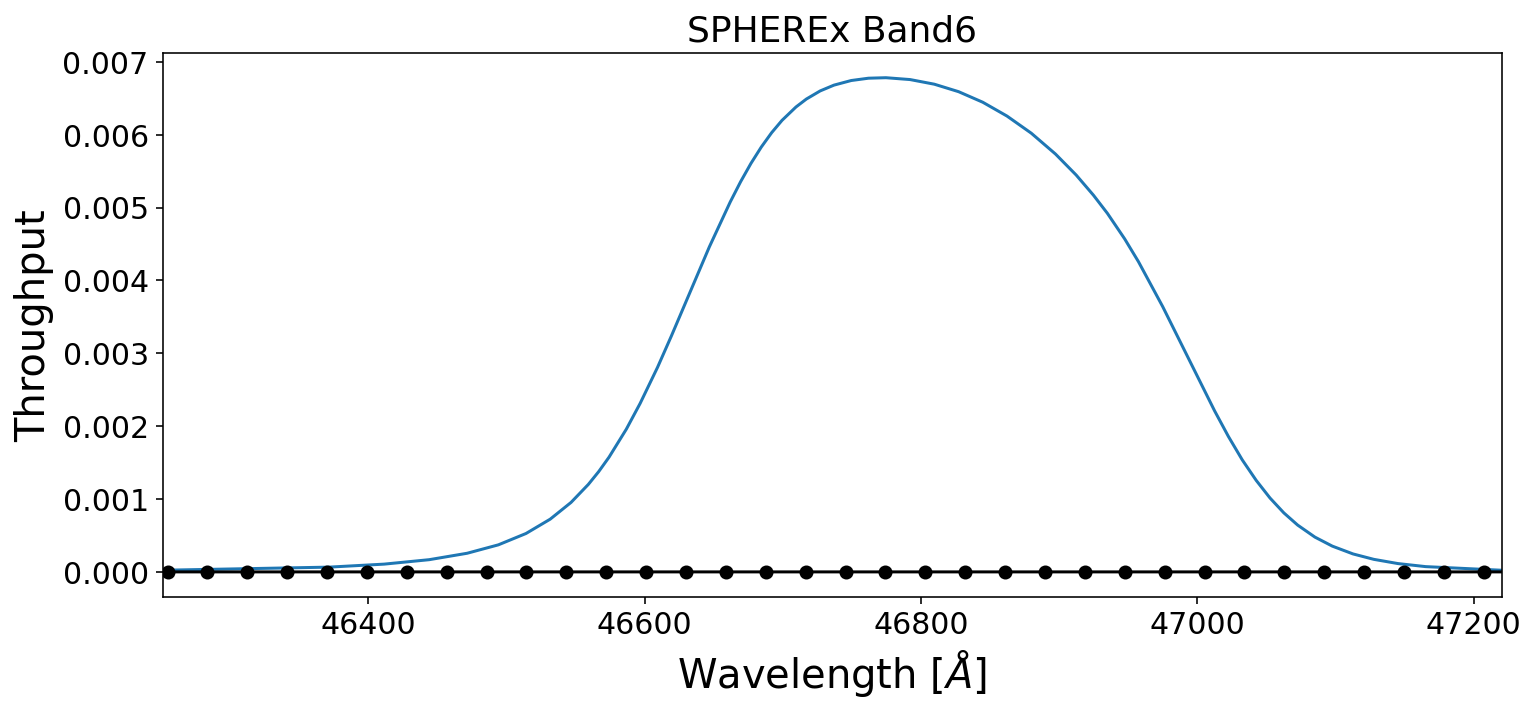

In [326]:
for band in range(1,7):
    idx_band = res.search(f'SPHEREx_Band{band}', verbose=False)
    res_band = np.array(res.filters)[idx_band]
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    filt = res_band[8]
    ax.plot(filt.wave, filt.throughput, 'tab:blue')
    ax.plot(lamb, np.zeros_like(lamb), 'o-k')
    ax.set_xlim(np.min(filt.wave), np.max(filt.wave))
    ax.set_xlabel(r'Wavelength [$\AA$]')
    ax.set_ylabel('Throughput')
    ax.set_title(f'SPHEREx Band{band}')

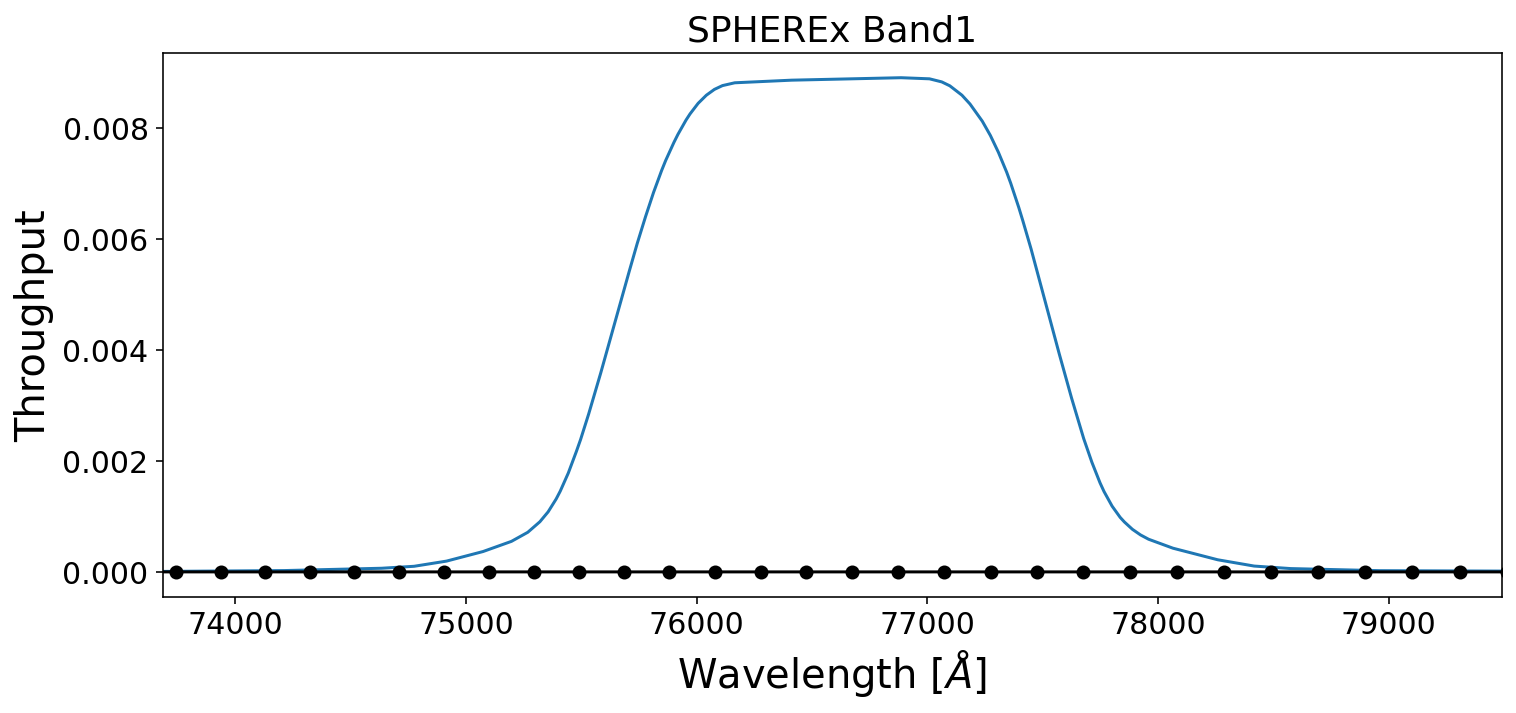

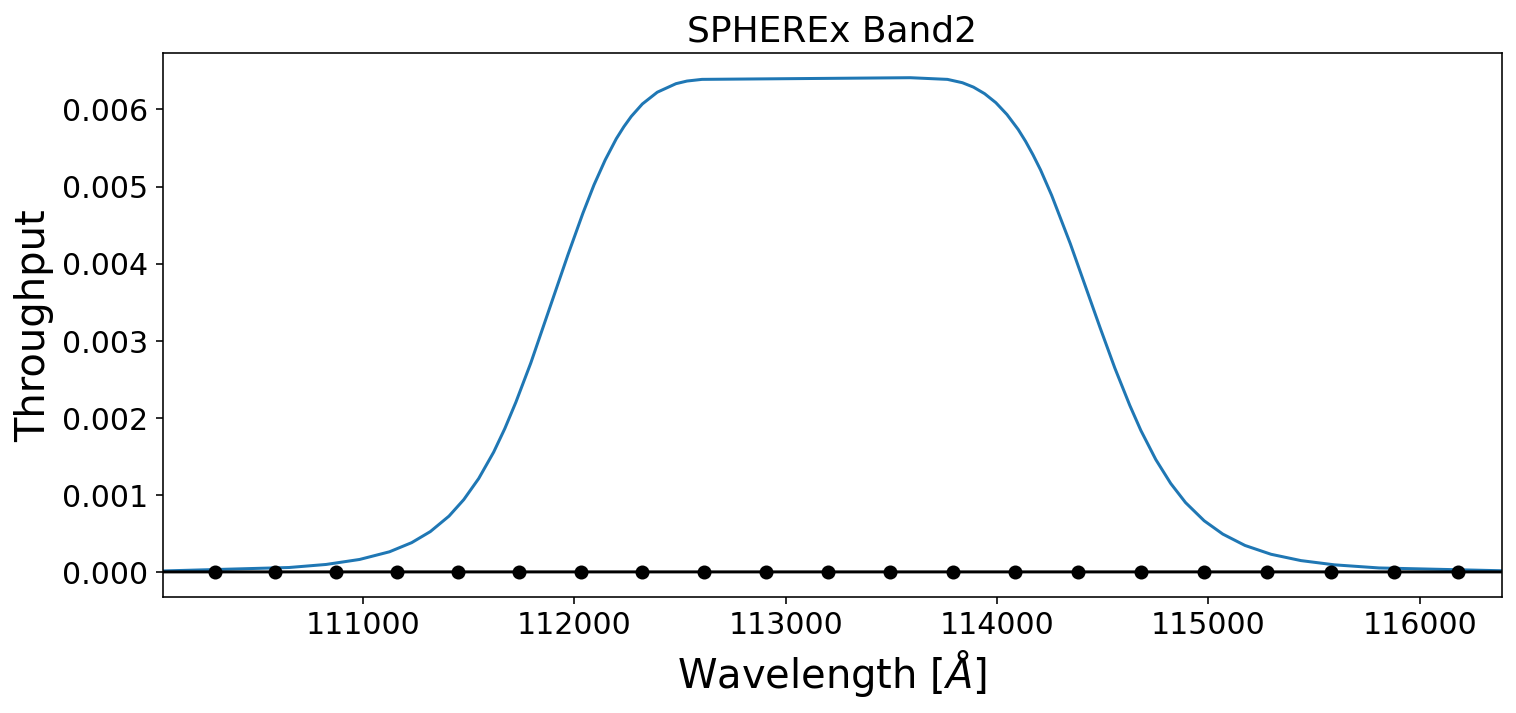

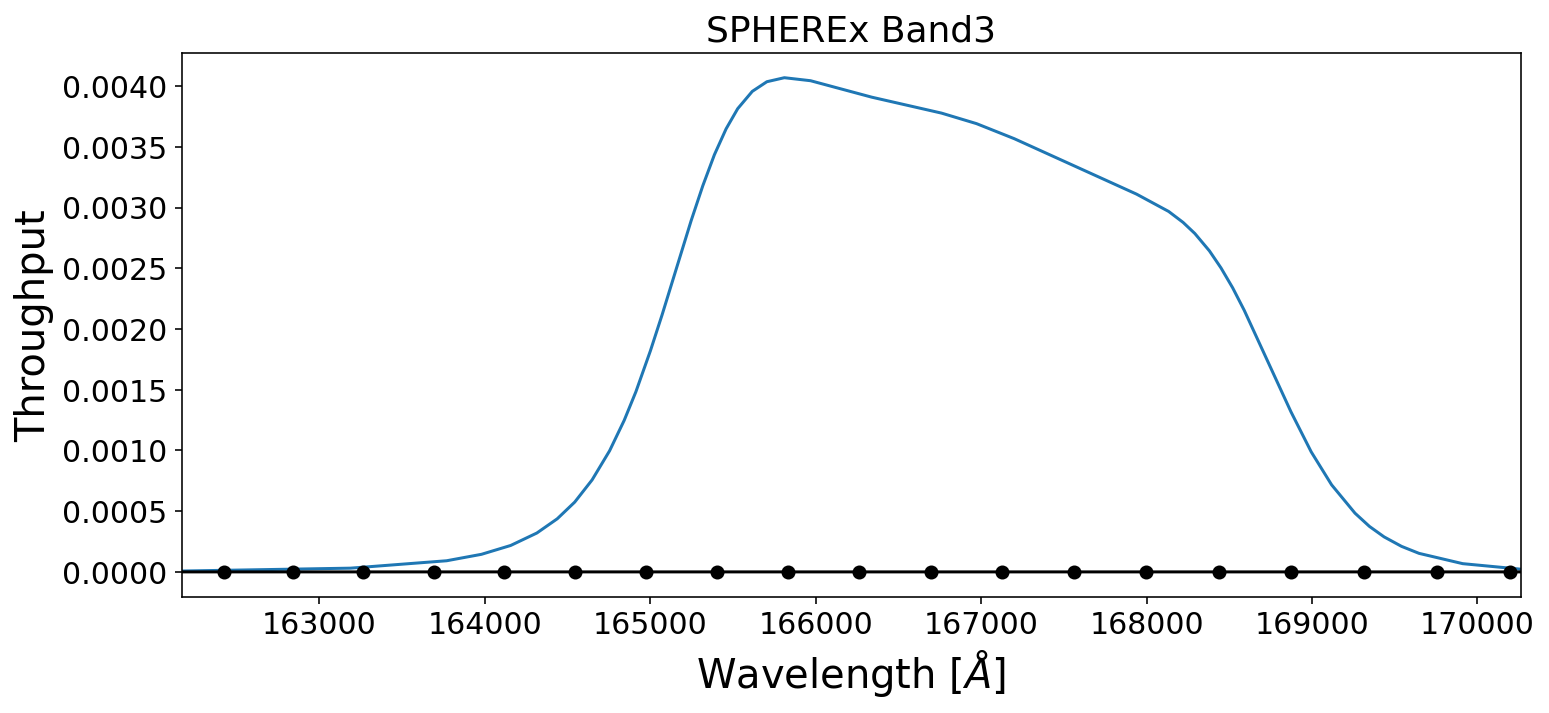

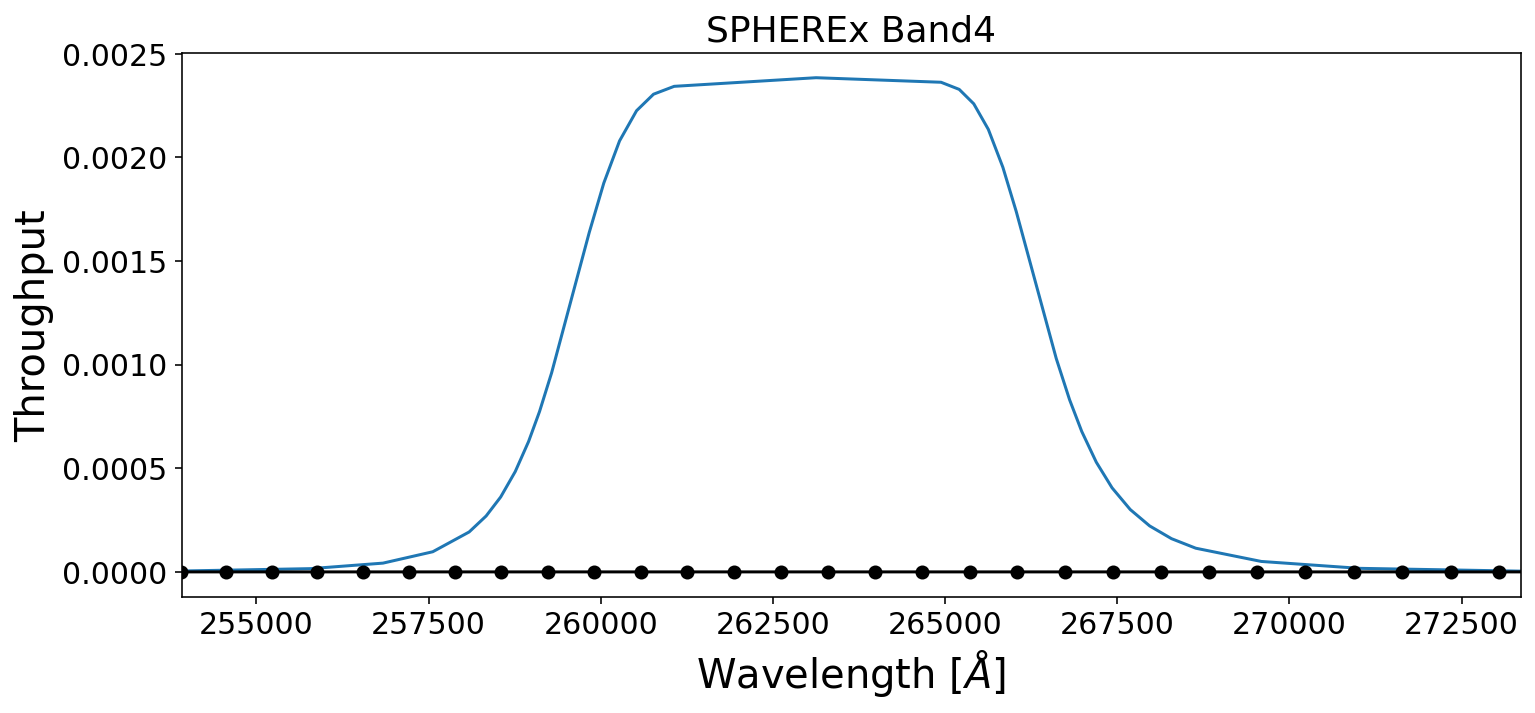

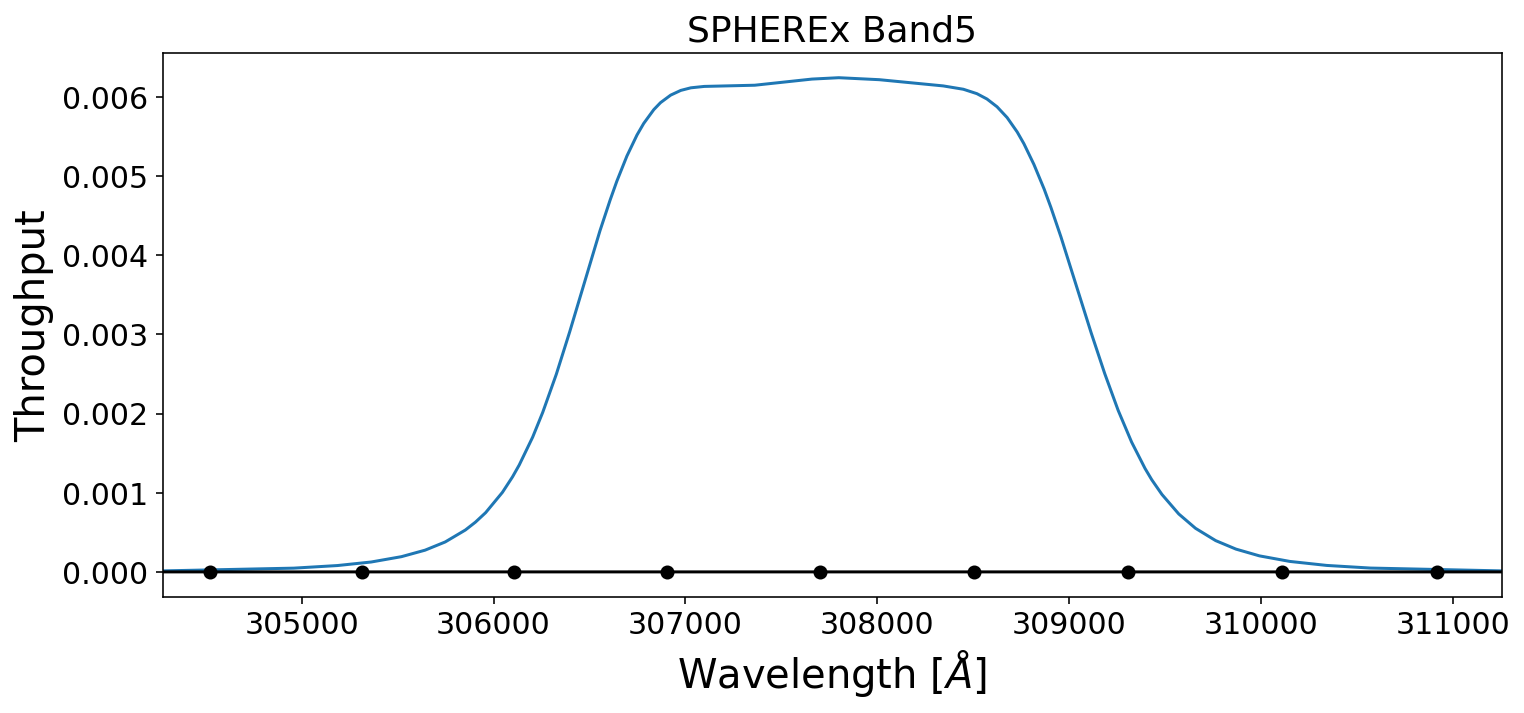

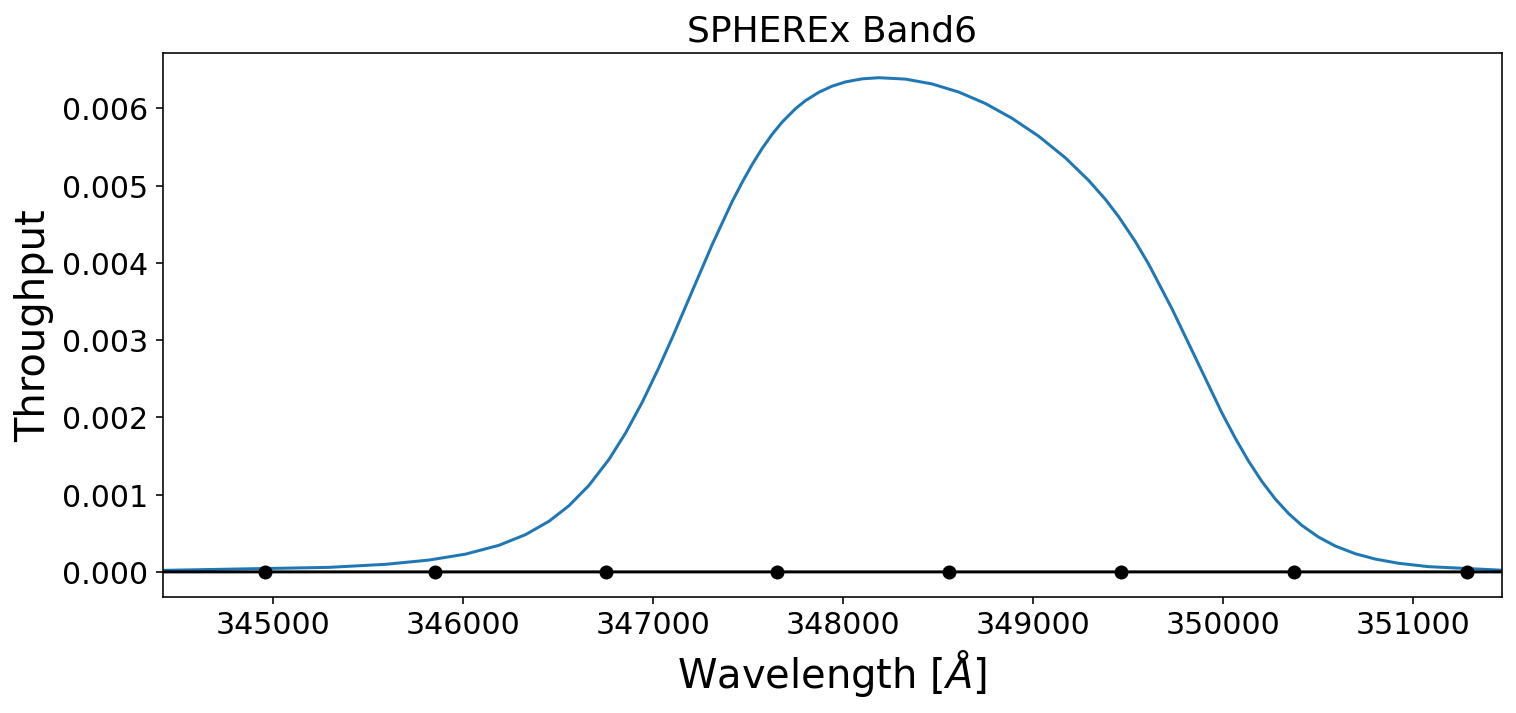

In [327]:
z = 6
for band in range(1,7):
    idx_band = res.search(f'SPHEREx_Band{band}', verbose=False)
    res_band = np.array(res.filters)[idx_band]
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    filt = res_band[16]
    ax.plot(filt.wave*(1+z), filt.throughput, 'tab:blue')
    ax.plot(lamb, np.zeros_like(lamb), 'o-k')
    ax.set_xlim(np.min(filt.wave*(1+z)), np.max(filt.wave*(1+z)))
    ax.set_xlabel(r'Wavelength [$\AA$]')
    ax.set_ylabel('Throughput')
    ax.set_title(f'SPHEREx Band{band}')